#Тестовое задание Chem Tech AI

В данном ноутбуке выполнено тестовое задание от компании Chem Tech AI.
Задача, которую предстоить выполнить, сформулирована следующим образом:
1. Используя данные представленные по ссылке Train_Data_200k создать модель, нацеленную на прогнозирование значений параметров **Target_1...4** по значениям **Tag_1...79**.
2. После получения модели применить ее к тестовой выборке представленной в архиве ML_Data в файле test_data_100k и на основании значений **Tag_1...79 **получить прогнозы для параметров **Target_1...4**.
3. Полученные прогнозы и топ-10 значимых тэгов направить в качестве результата в ответном письме.
4. Вложить рабочую тетрадь.


##Подключение библиотек

Для начала загрузим библиотеки, необходимые для выполнения задания.

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import catboost
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



##Загрузка данных

In [3]:
test_df = pd.read_csv('/content/drive/MyDrive/test_data_100k.csv')
train_df = pd.read_csv('/content/drive/MyDrive/train_data_200k.csv')

## Исследование данных

Теперь взглянем на данные

In [4]:
test_df.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,18.52599,39.32740,-0.000455,0.008434,-0.002304,0.001122,0.000523,0.000486,0.001575,15.60314,5.786203,3.869510,26.24795,80.58496,-1.582004,-3.424408,-3.334276,-3.876192,-1.179340,1.146502,5.792550,-1.916306,13.43756,-0.585351,40.78546,2.505804,NaN,NaN,86.76460,64.90110,NaN,NaN,16.46412,145.2561,17.68695,3.026593,0.0,175.3113,245.8068,61.43165,NaN,NaN,42.42581,NaN,NaN,72.65778,18.52599,39.32740,2.458516,0.474685,2.768988,NaN,NaN,2.788620,24.54365,24.18768,23.33983,33.42708,33.96873,NaN,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,18.52530,39.33560,-0.000480,0.008442,-0.002240,0.001128,0.000534,0.000485,0.001583,15.55087,5.781599,3.960081,26.23933,80.56205,-1.584656,-3.423789,-3.336082,-3.876512,-1.203795,1.156482,5.778395,-1.918682,13.76316,-0.599309,40.67742,2.493002,NaN,NaN,85.89352,64.45879,NaN,NaN,16.45829,144.6648,17.82857,2.992872,0.0,178.0342,246.3277,61.52076,36.99681,NaN,42.72885,NaN,NaN,72.67284,18.52530,39.33560,2.457176,0.474681,2.769368,NaN,NaN,2.789062,24.54758,24.17372,23.37887,33.51478,33.99389,NaN,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,18.52505,39.33189,-0.000564,0.008445,-0.002268,0.001129,0.000529,0.000486,0.001583,15.56572,5.808495,3.943974,26.26303,80.56678,-1.595108,-3.421828,-3.346181,-3.867854,-1.194099,1.155884,5.795678,-1.918225,14.24844,-0.603250,40.87209,2.482313,NaN,NaN,85.99540,64.29038,NaN,NaN,16.46561,144.5803,17.89324,3.022128,0.0,176.1473,245.7588,61.44187,37.06912,NaN,NaN,47.41304,NaN,72.67111,18.52505,39.33189,2.457504,0.474712,2.769572,NaN,NaN,2.789292,24.59129,24.19185,23.34789,33.45205,33.97408,NaN,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,18.52450,39.33465,-0.000569,0.008432,-0.002256,0.001152,0.000536,0.000488,0.001585,15.55563,5.826701,4.027435,26.29115,80.54873,-1.592608,-3.416253,-3.338829,-3.874055,-1.193421,1.138407,5.743540,-1.939878,14.40530,-0.603368,41.17179,2.490955,NaN,NaN,86.40989,64.54041,NaN,NaN,16.49379,144.7347,17.87374,3.033943,0.0,176.5516,246.0970,61.48563,37.14243,47.55349,NaN,NaN,NaN,72.67953,18.52450,39.33465,2.458431,0.474522,2.769539,NaN,NaN,2.789257,24.58162,24.16452,23.39324,33.39526,33.98973,NaN,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.52613,39.33673,-0.000699,0.008418,-0.002248,0.001126,0.000528,0.000476,0.001585,15.56986,5.784142,4.020133,26.27498,80.54944,-1.601977,-3.419028,-3.345777,-3.884507,-1.183772,1.123753,5.751623,-1.960477,14.44620,-0.615406,41.35782,2.474082,NaN,NaN,86.50966,64.28045,NaN,NaN,16.47419,143.7957,17.77529,3.002159,0.0,177.5667,246.1794,61.42502,36.30262,NaN,NaN,47.13390,NaN,72.69955,18.52613,39.33673,2.471320,0.470062,2.768945,NaN,NaN,2.788598,24.58673,24.18369,23.40569,33.49465,34.00968,NaN,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647


In [5]:
train_df.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30402,60.01311,-0.001269,0.018163,-0.000183,0.000671,0.000956,0.000858,0.000992,NaN,19.26714,22.33068,15.60123,80.97660,22.33527,33.87122,24.00339,57.06384,44.54309,23.80796,27.63220,47.27997,23.96099,23.94522,26.39192,47.87158,37.12356,36.37045,NaN,67.60985,...,NaN,NaN,NaN,183.3191,206.6534,69.99840,NaN,NaN,50.50632,46.30415,61.20765,72.77773,25.30402,60.01311,2.373747,0.677581,2.775156,1.769055,2.766034,2.794747,33.42513,34.27024,39.65590,44.48986,50.34106,37.34515,53.65030,50.70506,61.08673,72.76518,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,25.30464,60.01566,-0.001289,0.018208,-0.000210,0.000670,0.000947,0.000857,0.001003,25.31277,19.26205,22.35979,15.61021,80.98914,22.33696,33.89564,23.99264,57.05022,44.49367,23.81503,27.63496,47.27994,23.97050,23.93777,26.40619,47.86334,37.09820,36.26917,NaN,NaN,...,NaN,NaN,NaN,185.1547,205.3378,69.98409,NaN,NaN,50.49541,46.20826,61.20348,72.76062,25.30464,60.01566,2.373543,0.677852,2.775152,1.769295,2.766190,2.794963,33.41073,34.25732,39.70995,44.46941,50.31259,37.34732,53.65897,50.60955,61.09685,72.76947,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30486,60.01267,-0.001310,0.018185,-0.000146,0.000663,0.000957,0.000855,0.001004,NaN,19.26793,22.38500,15.59624,80.94573,22.33768,33.91651,23.98789,57.04745,44.52599,23.81206,27.63683,47.24675,23.96895,23.92040,26.36558,47.87779,37.10657,36.28939,91.98822,67.92857,...,NaN,NaN,NaN,185.7857,206.4609,70.04832,NaN,NaN,50.49607,46.24781,61.20309,72.76160,25.30486,60.01267,2.373388,0.677734,2.775619,1.768982,2.766650,2.795123,33.41452,34.23959,39.74942,44.45711,50.31557,37.32831,53.66189,50.60200,61.05627,72.75539,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,25.30544,60.01596,-0.000885,0.018180,-0.000192,0.000672,0.000949,0.000864,0.001003,NaN,19.24153,22.34216,15.60701,80.93867,22.33434,33.98246,23.98795,57.05103,44.51584,23.80859,27.62737,47.26019,23.94341,23.91153,26.39959,47.91307,37.14546,36.27222,NaN,NaN,...,NaN,NaN,NaN,182.6789,207.5279,69.95206,37.13296,NaN,50.51320,46.13975,61.28067,72.77470,25.30544,60.01596,2.385501,0.678970,2.775364,1.769024,2.766515,2.795122,33.40705,34.23381,39.79846,44.47630,50.28574,37.30737,53.67104,50.68343,61.00186,72.77387,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30540,60.01478,-0.001005,0.018167,-0.000113,0.000678,0.000955,0.000865,0.001013,NaN,19.25176,22.33690,15.60543,80.97723,22.33530,34.05027,23.98389,57.05997,44.51775,23.76636,27.64237,47.20809,23.93508,23.90270,26.37914,47.93106,37.13568,36.26667,NaN,NaN,...,NaN,NaN,NaN,186.6251,NaN,69.99007,NaN,NaN,50.50373,46.33209,61.28010,72.72731,25.30540,60.01478,2.385056,0.678937,2.775762,1.769598,2.766815,2.795541,33.37688,34.22705,39.81411,44.48069,50.23417,37.30698,53.58812,50.64983,61.04366,72.72121,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_df.shape

(200000, 84)

In [7]:
test_df.shape

(100000, 80)

Итак, мы видим, что:
1. Столбцы зашифрованы под именем tag с номером столбца.
2. Описания столбцов и данных нет.
3. Имеются пропуски.
4. Количество строк соответствует названию файла, количество столбцов разное (в тренировочном есть 4 столбца с целевым признаком, которые я запишу в отдельную переменную).

Посмотрим на типы данных и пропуски в датасетах.

In [8]:
target_columns = ['target1', 'target2', 'target3', 'target4']

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 84 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  200000 non-null  object 
 1   tag1        199934 non-null  float64
 2   tag2        109370 non-null  float64
 3   tag3        109456 non-null  float64
 4   tag4        85 non-null      float64
 5   tag5        9736 non-null    float64
 6   tag6        373 non-null     float64
 7   tag7        88122 non-null   float64
 8   tag8        16777 non-null   float64
 9   tag9        407 non-null     float64
 10  tag10       199837 non-null  float64
 11  tag11       199867 non-null  float64
 12  tag12       199875 non-null  float64
 13  tag13       199875 non-null  float64
 14  tag14       199875 non-null  float64
 15  tag15       199875 non-null  float64
 16  tag16       199875 non-null  float64
 17  tag17       199875 non-null  float64
 18  tag18       199875 non-null  float64
 19  ta

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  object 
 1   tag1        99828 non-null   float64
 2   tag2        0 non-null       float64
 3   tag3        0 non-null       float64
 4   tag4        78 non-null      float64
 5   tag5        14939 non-null   float64
 6   tag6        253 non-null     float64
 7   tag7        15075 non-null   float64
 8   tag8        22888 non-null   float64
 9   tag9        94 non-null      float64
 10  tag10       99828 non-null   float64
 11  tag11       99828 non-null   float64
 12  tag12       99833 non-null   float64
 13  tag13       99836 non-null   float64
 14  tag14       99836 non-null   float64
 15  tag15       99836 non-null   float64
 16  tag16       99827 non-null   float64
 17  tag17       99836 non-null   float64
 18  tag18       99836 non-null   float64
 19  tag

Все данные числовые типа *float64*, за исключением первого столбца, который очевидно представляет из себя тип datetime, но считан как *object*. При очистке данных я это исправлю.

Количество пропусков в столбцах варируется от почти полного датасета до нескольких экземпляров. Исключение - первый столбец с временем и датой, он не содержит пропусков.

Теперь посмотрим на описательную статистику, используя метод *describe()*.

In [11]:
train_df.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,100168.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,39220.000000,38048.000000,1.583080e+05,152970.000000,15578.000000,...,1.117250e+05,1.138000e+05,98410.0,1.998670e+05,132355.000000,199866.000000,78120.000000,14722.000000,101792.000000,84189.000000,59443.000000,199867.000000,199837.000000,199867.000000,199837.000000,199119.000000,199875.000000,35810.000000,36726.000000,199875.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,37652.000000,199867.000000,199867.000000,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,20.305728,11.696598,13.797841,11.759747,81.016135,19.222866,8.782267,10.878145,20.160856,17.093377,25.379681,26.202377,20.609791,5.374740,19.468993,10.680114,23.355227,35.503725,34.075806,7.990204e+01,59.421573,40.916190,...,1.761049e+01,1.316814e+00,0.0,1.848092e+02,245.337823,69.513164,43.837855,45.891781,46.728568,46.626250,59.817989,72.660003,23.584873,50.128928,2.415533,0.716383,2.769036,1.769548,2.763237,2.793360,20.816438,26.055005,28.467759,43.801585,38.095371,35.714963,43.459269,50.051799,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,4.028258,6.351744,6.973005,5.400680,0.562162,13.288055,19.251651,9.765605,29.312477,23.205521,15.660261,11.451187,25.272481,14.370803,9.534630,15.769529,21.636223,3.704882,4.235066,5.119445e+00,3.839873,2.699708,...,3.041737e+00,9.415702e-01,0.0,6.731712e+00,18.389717,4.449915,3.705196,3.696100,3.468820,2.981598,3.227836,0.214569,4.877921,16.948128,0.186903,0.179985,0.036395,0.003708,0.008499,0.007465,11.133341,3.790688,7.818537,1.117651,8.392762,3.534464,7.486956,1.536693,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,0.000000,-10.558860,-9.543885,-19.495170,68.816150,-7.698016,-34.570690,-14.961360,-34.654410,-30.909190,-4.582263,2.232100,-29.993390,-37.930990,-6.355927,-34.072190,-21.258420,18.954950,15.042280,6.259399e-07,0.020922,20.059580,...,2.313189e-25,2.303353e-25,0.0,6.076754e-19,0.000218,19.210710,22.781390,28.341410,24.284860,27.575620,37.753350,67.914190,8.848302,-0.050376,1.947665,-0.000511,0.000097,1.703969,2.574159,2.599954,0.000000,15.118610,-4.038994,33.356780,18.640790,18.862820,23.278410,40.573780,43.124100,67.901700,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.9185

И такую же статистику отдельно по целевым показателям.

In [12]:
train_df[target_columns].describe()

,target1,target2,target3,target4
count,199991.000000,199991.000000,199991.000000,199991.000000
mean,0.001156,0.049836,0.942428,0.006580
std,0.000085,0.003685,0.003936,0.001442
min,0.000826,0.035611,0.912861,0.002595
25%,0.001101,0.047461,0.940184,0.005565
50%,0.001155,0.049773,0.942605,0.006435
75%,0.001206,0.051962,0.945057,0.007307
max,0.001865,0.080406,0.956497,0.014346


Все значения целевых показателей находятся в интервале между 0 и 1. Разброс значений очень небольшой, это необходимо будет учесть при выборе метрики для валидации модели.

В столбцах-признаках имеются данные разных масштабов. Пожалуй, имеет смысл нормализовать признаки и привести их к одному масштабу.

##Немного визуализации

Взглянем, на что похожи диаграммы распределения данных. Сначала в целевых столбцах.

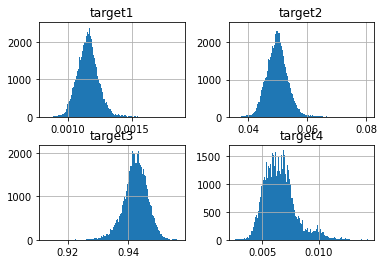

In [13]:
train_df[target_columns].hist(bins = 500)
plt.show()

Каждый график имеет нормальное распределение, но в **target4** всё не так однозначно, как в других. Имеется некоторое смещение вправо, и в шапке есть разброс значений.

Теперь посмотрим на распределения остальных столбцов в тренировочной выборке.

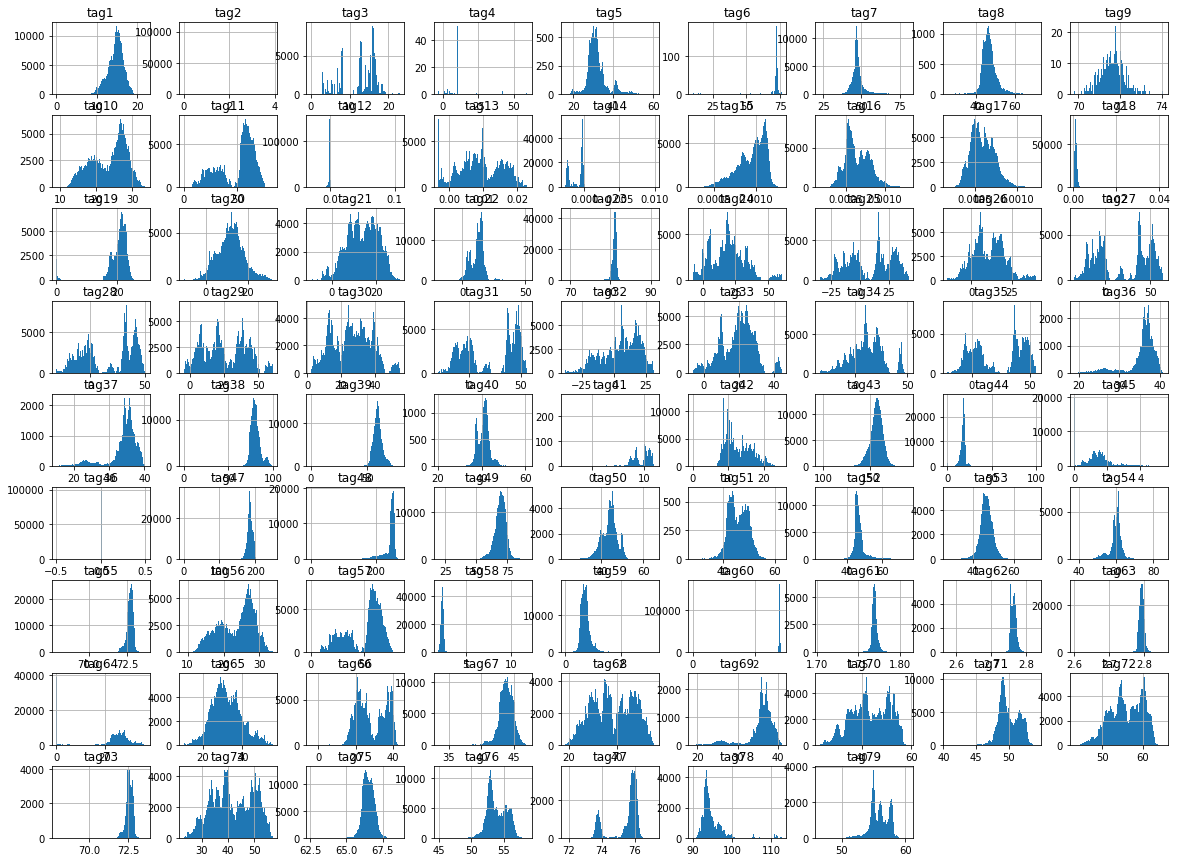

In [14]:
train_df.drop(columns = target_columns).hist(figsize = (20,15), bins = 100)
plt.show()

И то же самое для тестовой выборки.

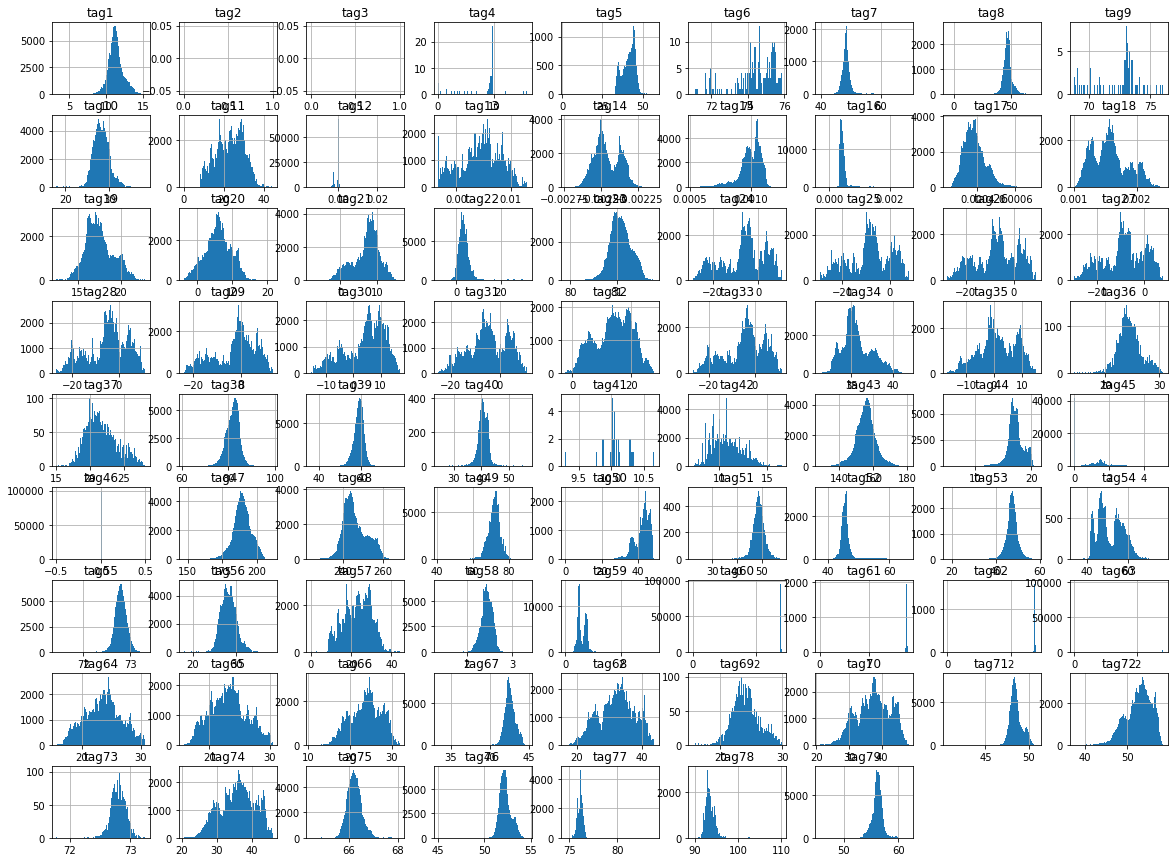

In [15]:
test_df.hist(figsize = (20,15), bins = 100)
plt.show()

Многие диаграммы имеют вид Гауссовых распределений. Кроме разве что столбцов **tag21-tag35**, ну и разумеется, столбцов с большим количеством пропусков.

Теперь посмотрим на карту пропущенных значений. Для начала с тренировочным датасетом.

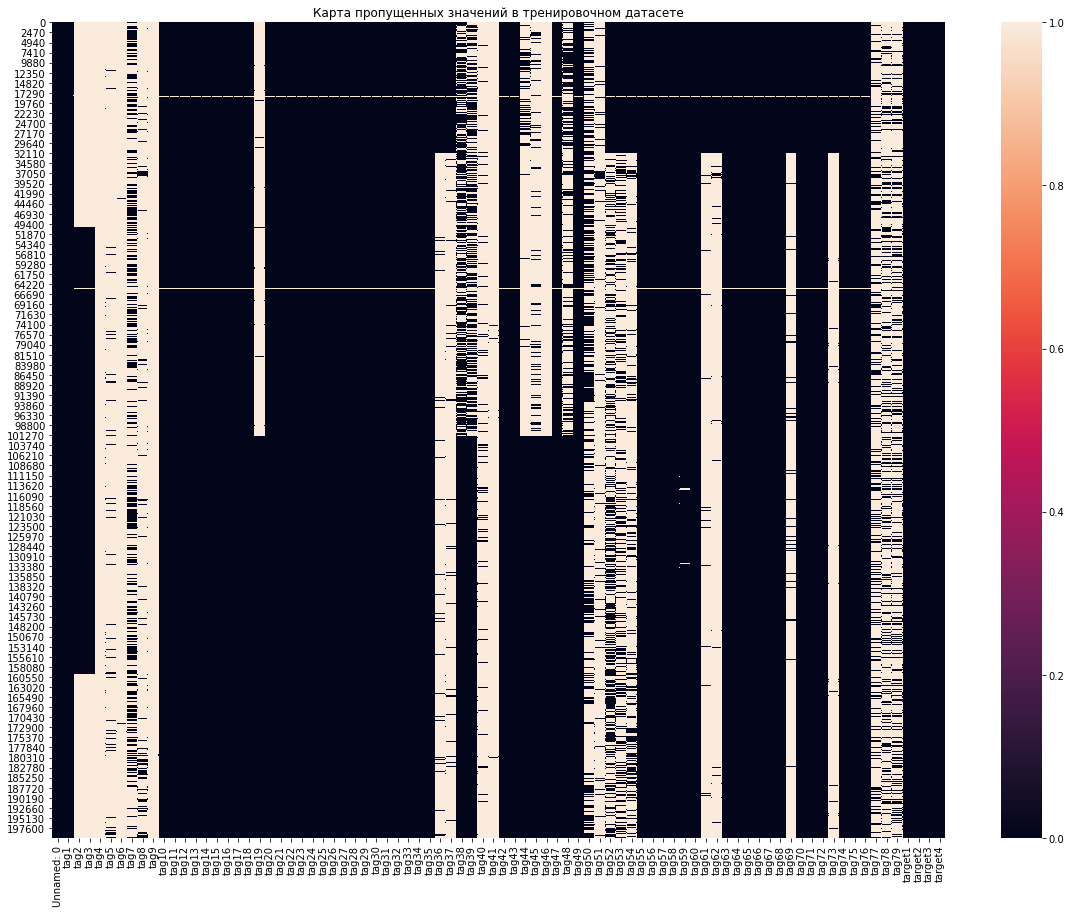

In [16]:
plt.figure(figsize = (20,15))
plt.title('Карта пропущенных значений в тренировочном датасете')
sns.heatmap(train_df.isna())
plt.show()

Теперь с тестовым.

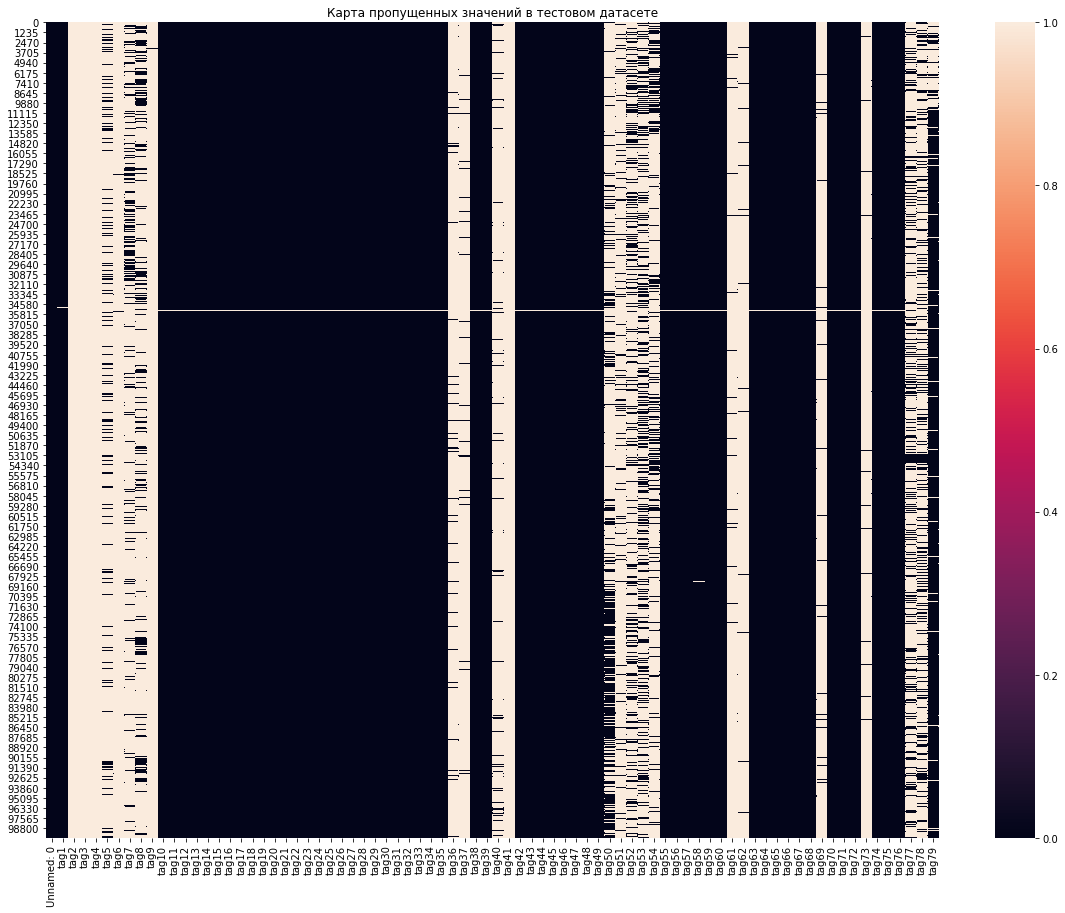

In [17]:
plt.figure(figsize = (20,15))
plt.title('Карта пропущенных значений в тестовом датасете')
sns.heatmap(test_df.isna())
plt.show()

Интересная картина - в некоторых столбцах пропущенные значения сосредоточены в одной части датасета. Если посмотреть на первые строчки датасета, то можно увидеть, что каждая строка имеет в первом столбце шаг в одну минуту, и похоже что весь датасет упорядочен по времени. Можно сделать пердположение, что такая системность в пропусках зависит от времени. 200 000 минут составит почти 139 дней, и скорее всего тут наблюдается сезонность в данных.

Это создаёт диллему - если просто удалить столбцы или строки с данными, то подобная зависимость может оказаться скрыта и модель будет менее точной.

С диллемой разберёмся позже, а пока проверим датасет на наличие зависимостей. Для этого мы воспользуемся корреляционной картой.

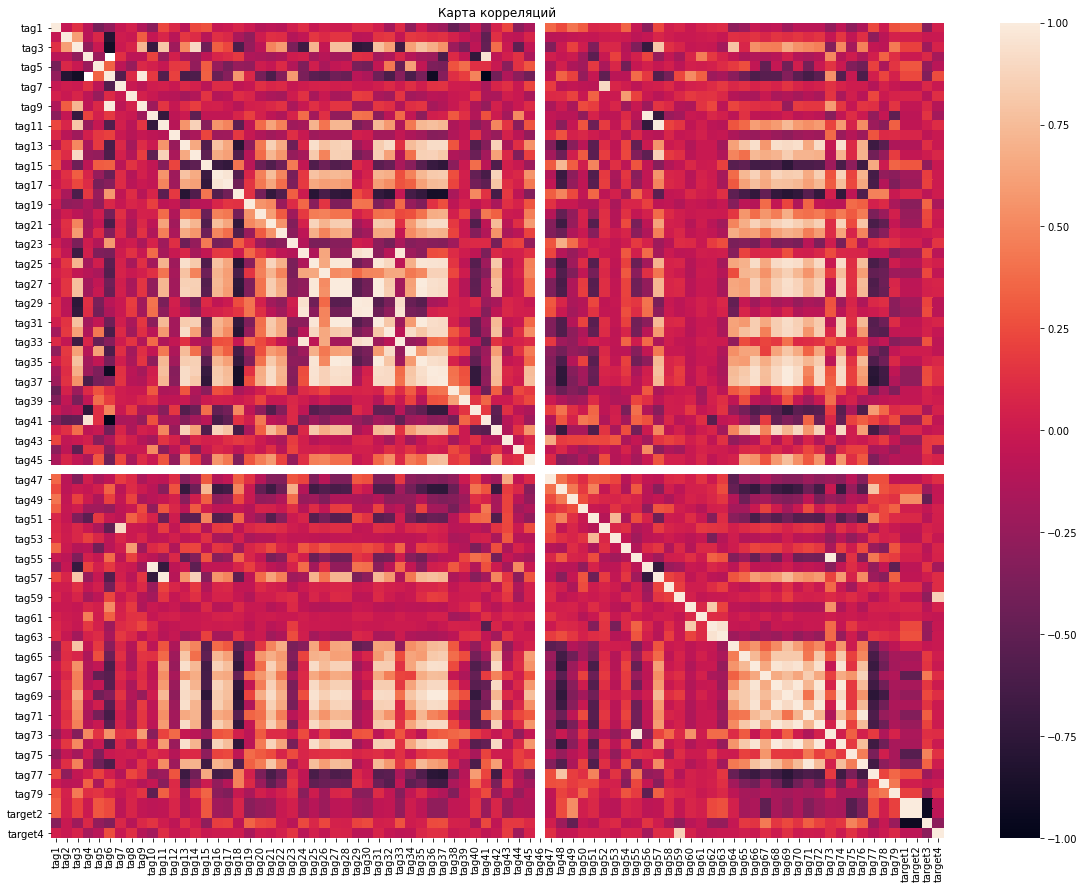

In [18]:
plt.figure(figsize = (20,15))
plt.title('Карта корреляций')
sns.heatmap(train_df.corr())
plt.show()

В первую очередь нас интересуют зависимости целевых показателей (**target1-4**). 

Похоже, что **target1** и **target2** линейно зависимы между собой, в то время как **target3** имеет прямую обратную зависимость к ним. **Target4** в какой-то степени коррелирует (отрицательно) с **target3**.

Столбец-признак **tag59** имеет сильную корреляцию с **target4**.

Столбец **tag46** вообще не имеет никаких корреляций. Надо проверить его значения.



In [19]:
train_df.tag46.value_counts()

0.0    98410
Name: tag46, dtype: int64

**tag46** не несёт какой-либо полезной информации для модели. В нём либо пропуски, либо нули. При очистке данных я его удалю.

Теперь посмотрю на график зависимости **target4** от **tag59**.

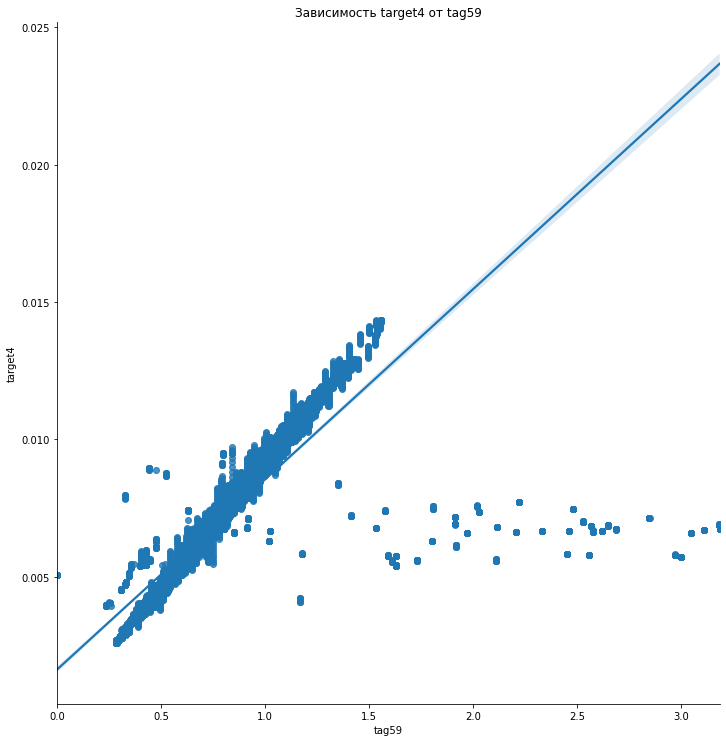

In [20]:
sns.lmplot(x = 'tag59', y = 'target4', data = train_df, height = 10)
plt.title('Зависимость target4 от tag59')
plt.show()

Видно основную группу с линейной зависимостью, а также ряд выбросов. Вопрос - нужно ли их удалить, как лишний шум для модели, или же они представляют собой ценность?
Сейчас посмотрим на корреляции тестовых данных - выглядят ли они также?

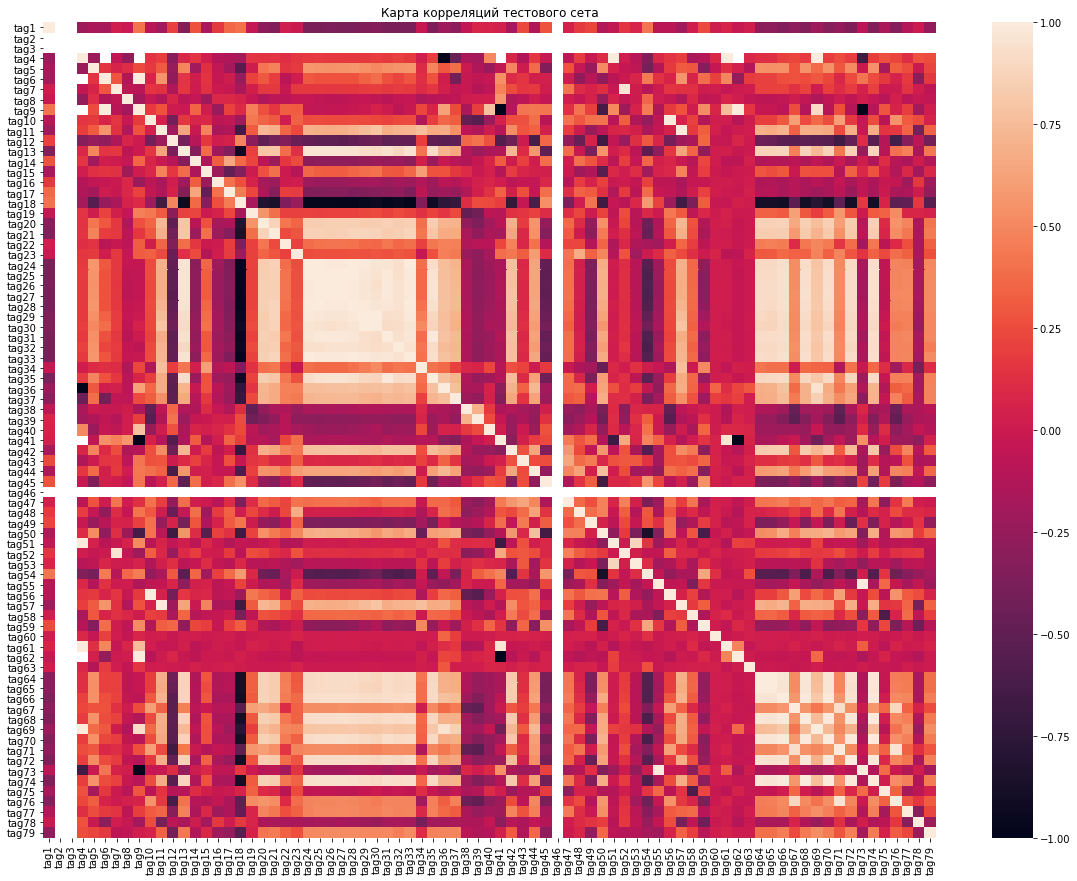

In [21]:
plt.figure(figsize = (20,15))
plt.title('Карта корреляций тестового сета')
sns.heatmap(test_df.corr())
plt.show()

Столбцы **tag2** и **tag3** не имеют значений. Столбцы с **tag24** по **tag33** обладают очень сильной корреляцией между собой и несколькими другими столбцами. Возможно от них тоже стоит избавиться. Однако, почему же в тренировочной выборке корреляция иная? Ниже на графике я исследую статистическую зависимость столбцов **tag27** и **tag30**, которые показали слабую зависимость в тренировочной выборке, но сильную в тестовой.

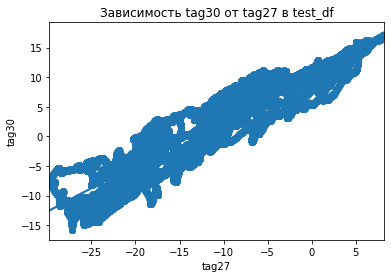

In [22]:
sns.regplot(x = 'tag27', y = 'tag30', data = test_df)
plt.title('Зависимость tag30 от tag27 в test_df')
plt.show()

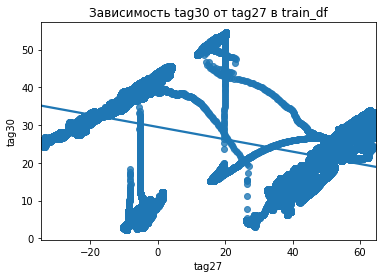

In [23]:
sns.regplot(x = 'tag27', y = 'tag30', data = train_df)
plt.title('Зависимость tag30 от tag27 в train_df')
plt.show()

Данные странным образом разбиты на участки. Масштаб одной и другой переменной изменён. Возможно, их всё-таки лучше удалить.

##Первичная(минимальная) обработка данных

###Преобразование типа данных

Для начала сконвертирую столбец **Unnamed: 0** в соответствующий ему тип данных - *datetime*. Ну и заодно дам ему это же имя

In [24]:
train_df['Unnamed: 0'] = pd.to_datetime(train_df['Unnamed: 0'])
train_df.rename({'Unnamed: 0': 'datetime'}, axis = 1, inplace = True)

Сразу же проверю, упорядочен ли столбец строго по возрастанию и нет ли там ошибочно дублированных записей

In [25]:
train_df.datetime.is_monotonic_increasing and train_df.datetime.is_unique

True

### Удаление пропущенных значений

Далее я избавлюсь от строк, где целевые значения в тренировочном наборе данных пропущены.

In [26]:
train_df.dropna(subset = target_columns, inplace = True)

## Построение первичной модели

В этом разделе я обучу модель без предварительной подготовки данных. После валидации я получу результат, с которым я буду сверяться при попытках улучшения модели. Модель, которую я выбрал - алгоритм градиентного бустинга от Яндекса CatboostRegressor

In [27]:
raw_model = catboost.CatBoostRegressor(objective = 'MultiRMSE', random_state = 10)

Мне нужно разделить тренировочный датасет для валидации. Но в данных есть особенность - датасет упорядочен по времени. Если делить случайным образом и перемешивать строки, то это упорядоченность пропадёт. В таком случае я разобью их вручную в соотношении 4 к 1, и тестовая выборка составит последние 20% значений. В качестве метрики буду использовать R^2 и RMSE, функции для определения значений этих метрик возьму из библиотеки sklearn.

In [28]:
raw_X = train_df.drop(columns = target_columns + ['datetime'])
raw_y = train_df[target_columns]

In [29]:
raw_X_train = raw_X.iloc[:160000]
raw_X_test = raw_X.iloc[160000:]
raw_y_train = raw_y.iloc[:160000]
raw_y_test = raw_y.iloc[160000:]

Далее обучу модель. Она не должна дать хороших результатов, однако даст нам понять впоследствии, насколько хорошо нам получилось подготовить данные.

In [30]:
raw_model.fit(raw_X_train,raw_y_train)

0:	learn: 0.0053446	total: 525ms	remaining: 8m 44s
1:	learn: 0.0052648	total: 887ms	remaining: 7m 22s
2:	learn: 0.0051866	total: 1.22s	remaining: 6m 44s
3:	learn: 0.0051117	total: 1.57s	remaining: 6m 32s
4:	learn: 0.0050393	total: 1.96s	remaining: 6m 29s
5:	learn: 0.0049687	total: 2.33s	remaining: 6m 26s
6:	learn: 0.0049000	total: 2.71s	remaining: 6m 23s
7:	learn: 0.0048340	total: 3.13s	remaining: 6m 27s
8:	learn: 0.0047675	total: 3.53s	remaining: 6m 28s
9:	learn: 0.0047052	total: 3.94s	remaining: 6m 30s
10:	learn: 0.0046435	total: 4.28s	remaining: 6m 24s
11:	learn: 0.0045847	total: 4.61s	remaining: 6m 19s
12:	learn: 0.0045295	total: 4.95s	remaining: 6m 15s
13:	learn: 0.0044721	total: 5.29s	remaining: 6m 12s
14:	learn: 0.0044174	total: 5.7s	remaining: 6m 13s
15:	learn: 0.0043650	total: 6.06s	remaining: 6m 12s
16:	learn: 0.0043137	total: 6.46s	remaining: 6m 13s
17:	learn: 0.0042636	total: 6.85s	remaining: 6m 13s
18:	learn: 0.0042126	total: 7.21s	remaining: 6m 12s
19:	learn: 0.0041600	to

In [31]:
raw_predictions = raw_model.predict(raw_X_test)
print('Метрика R^2 показала результат ' + str(r2_score(raw_y_test, raw_predictions)))
print('Метрика RMSE показала результат ' + str(mean_squared_error(raw_y_test, raw_predictions, squared = False)))

Метрика R^2 показала результат 0.6798904963585414
Метрика RMSE показала результат 0.001891481154464504


Итак, значение коэффициента детерминации R^2 приблизительно 0.68, что далеко от единицы, наши предсказанные значения не так сильно коррелируют с реальными, как того хотелось бы. Но опять же, это модель без очистки данных и настройки параметров. Этот результат нам необходимо улучшать.

In [32]:
raw_model.get_feature_importance(prettified = True)[:10]

,Feature Id,Importances
0,tag49,23.210903
1,tag59,16.047492
2,tag42,12.536421
3,tag58,9.255271
4,tag75,9.004069
5,tag43,7.134551
6,tag67,5.519014
7,tag63,3.531569
8,tag2,2.202232
9,tag1,2.116541


Здесь отобраны 10 наиболее важных для алгоритма признаков по версии нашей "сырой" модели. Можно отметить, что первые два признака в этом списке обладают наибольшей корреляцией согласно карте корреляций, нарисованной выше. **tag49** сильнее остальных признаков коррелирует с первыми тремя целевыми столбцами, а **tag59** обладает очень больлшой корреляцией с столбцом **target4**. Это определённо имеет смысл.

В конце мы сопоставим эти признаки с теми, которые посчитает важными наша финальная модель.

##Предобработка данных

В этом разделе я буду обрабатывать данные согласно тем выводам, которые я получил при исследовании и визуализации датасета. После всего я объеденю всю процедуру в одну функцию, чтобы применить её же к тестовой части.

###Удаление столбцов

Столбцы **tag2** и **tag3** не нужны - в тестовой части эти значения попросту отсутствуют. **tag46** тоже не несёт полезной информации для нашего датасета. **tag4**, **tag6**, **tag9**, **tag41** обладают слишком маленьким количеством значений в обоих наборах данных. Столбцы **tag24**-**tag33** Имеют очень высокую корреляцию между собой и другими столбцами в тестовой части.

In [33]:
columns_to_drop = ['tag2',
                   'tag3',
                   'tag4',
                   'tag6',
                   'tag9',
                   'tag24',
                   'tag25',
                   'tag26',
                   'tag27',
                   'tag28',
                   'tag29',
                   'tag30',
                   'tag31',
                   'tag32',
                   'tag33',
                   'tag41',
                   'tag46']

In [34]:
train_df.drop(columns = columns_to_drop, inplace = True)

### Удаление выбросов

Нужно с осторожностью подходить к удалению выбросов. С одной стороны, их наличие может существенно снизить возможности алгоритма находить статистическую взаимосвязь в данных. Но с другой, если удалять все выбросы бездумно, то мы можем получить некорректную картину, где вариативность в данных будет меньше, чем она есть на самом деле. Предсказательные способности могут стать более чёткими, но при этом ошибочными, не учитывающими естественные выбросы в данных.

Поэтому перед удалением выброса мне необходимо определить, являются ли они ошибкой или же это естественное отклонение. Разумеется, моя оценка будет субъективной, так как данные абстрактны.

Для определения выбросов мне снова необходимо свериться с диаграммами распределений.

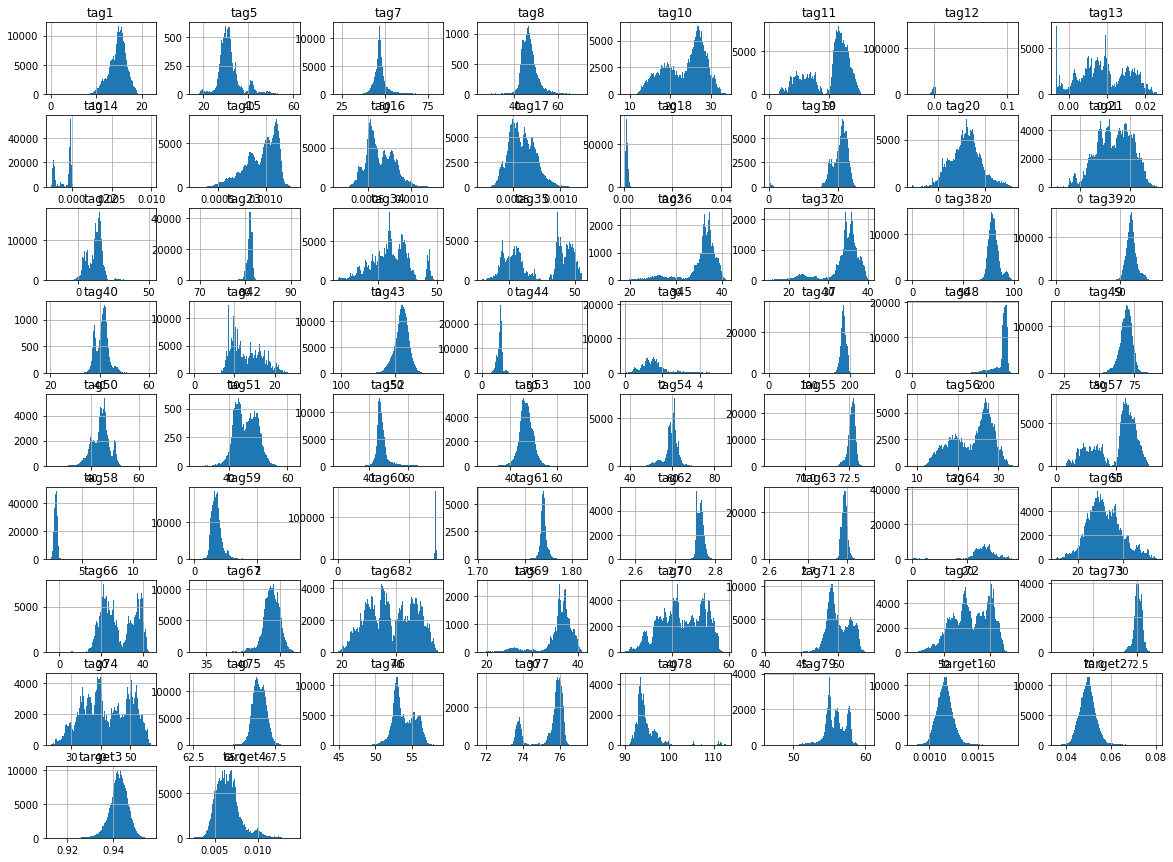

In [35]:
train_df.hist(figsize = (20,15), bins = 100)
plt.show()

Подозрение вызывают столбцы **tag12**, **tag14**, **tag18**, **tag44**, **tag45**, **tag58**, **tag60**, **tag64**, **tag78**.

Каждый из этих столбцов я исследую на выбросы.


#### tag12

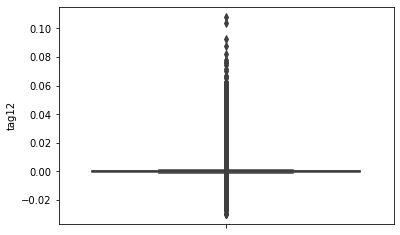

In [36]:
sns.boxplot(y = train_df.tag12)
plt.show()

In [37]:
train_df.tag12[train_df.tag12 > 0.01]

35320    0.011655
35345    0.017865
35347    0.011392
35349    0.015684
35351    0.013800
           ...   
38448    0.025087
38449    0.016206
38451    0.014844
38452    0.020214
38453    0.011945
Name: tag12, Length: 943, dtype: float64

График "Ящик с усами" показывает, что как минимум половина всех значений сосредоточена у нуля. Исследовав выбросы (значения более 0,01), я увидел, что все они имеют близкий друг другу индекс. Скорее всего эти выбросы появились в результате какого-то события во времени.

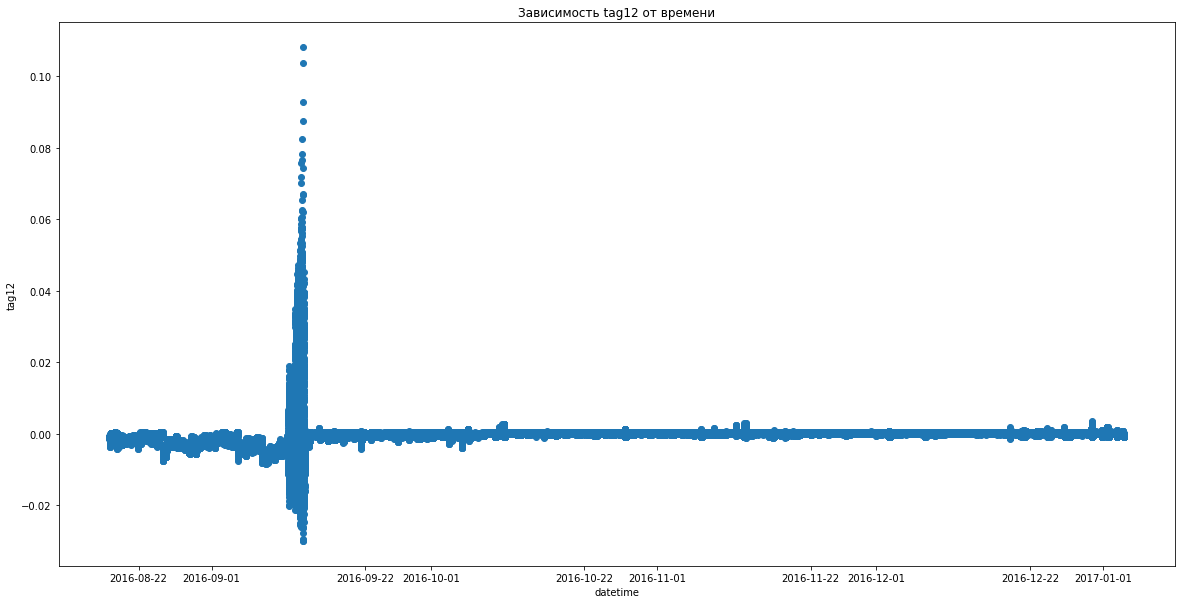

In [38]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', y = 'tag12', data = train_df)
plt.title('Зависимость tag12 от времени')
plt.xlabel('datetime')
plt.ylabel('tag12')
plt.show()

Ого! Картина очень интригующая. Попробую масштабировать график в районе выбросов

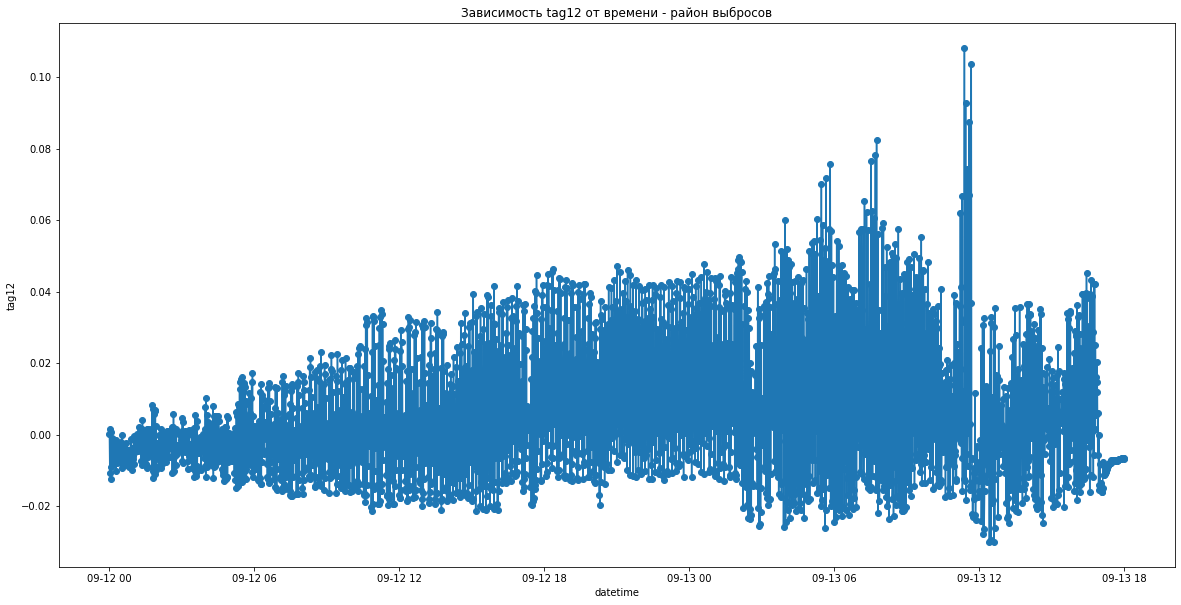

In [39]:
condition_for_tag12 = train_df.datetime > datetime.datetime(2016,9,12)
condition_for_tag12_2 = train_df.datetime < datetime.datetime(2016,9,13,18)
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag12', 
              data = train_df[(condition_for_tag12 & condition_for_tag12_2)],
              ls = '-')
plt.title('Зависимость tag12 от времени - район выбросов')
plt.xlabel('datetime')
plt.ylabel('tag12')
plt.show()

Похоже, что значения сильно разбрасываются из одного конца в другой. Пожалуй, стоит их удалить, так как предсказать такое хаотическое поведение модель не сможет, но на остальную область эти выбросы будут очень сильно воздействовать.

In [40]:
train_df.tag12[train_df.tag12 > 0.002] = np.nan
train_df.tag12[train_df.tag12 < -0.002] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


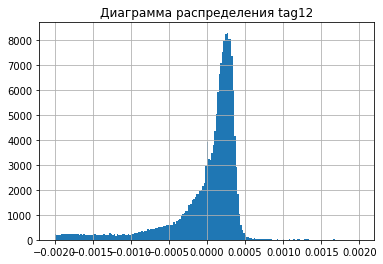

In [41]:
train_df.tag12.hist(bins=200)
plt.title('Диаграмма распределения tag12')
plt.show()

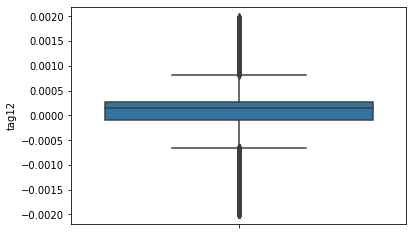

In [42]:
sns.boxplot(y = train_df.tag12)
plt.show()

Заодно проверю, будет ли подобная чистка справедлива для тестового датасета

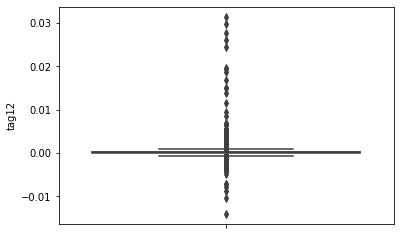

In [114]:
sns.boxplot(y = test_df.tag12)
plt.show()

Вывод - да, в тестовом те же проблемы.

####tag14

Следующий на очереди **tag14**.

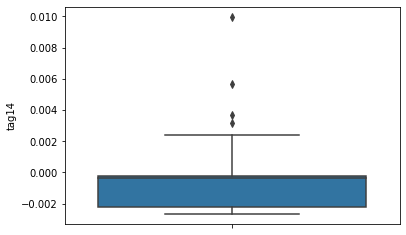

In [43]:
sns.boxplot(y = train_df.tag14)
plt.show()

In [44]:
train_df.tag14[train_df.tag14 > 0.0002]

45256     0.001523
45258     0.002407
45259     0.001150
45260     0.003645
45261     0.002198
45265     0.000925
56807     0.000226
111451    0.000316
111458    0.000347
111461    0.009974
135924    0.005679
143858    0.003194
166012    0.001664
182606    0.001510
Name: tag14, dtype: float64

Все эти выбросы я удалю - они немногочисленны, кажутся разрозненными и повлияют на столбец при масштабировании.

In [45]:
train_df.tag14[train_df.tag14 > 0.0002] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


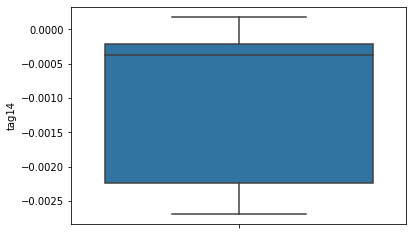

In [46]:
sns.boxplot(y = train_df.tag14)
plt.show()

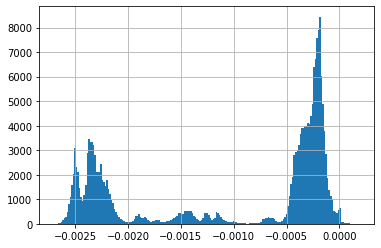

In [47]:
train_df.tag14.hist(bins = 200)
plt.show()

Теперь проверю, соответствует ли эта проблема тестовому датасету

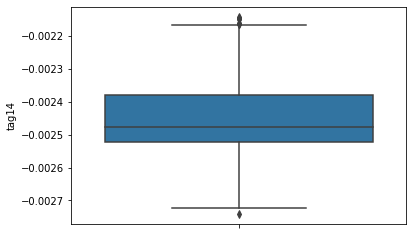

In [115]:
sns.boxplot(y = test_df.tag14)
plt.show()

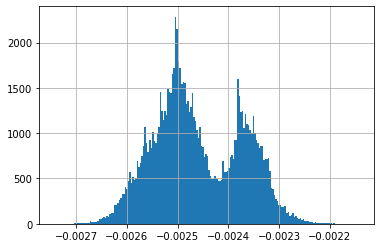

In [116]:
test_df.tag14.hist(bins = 200)
plt.show()

Вывод - нет, не соответствует

Теперь приступим к **tag18**

####tag18

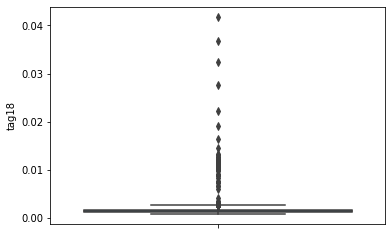

In [48]:
sns.boxplot(y = train_df.tag18)
plt.show()

In [49]:
train_df.tag18[train_df.tag18 > 0.01]

187762    0.010366
187763    0.010528
187764    0.010481
187765    0.010840
187766    0.010856
            ...   
188658    0.016444
188659    0.014460
188660    0.013265
188661    0.011765
188662    0.010645
Name: tag18, Length: 88, dtype: float64

Кажется, эти выбросы тоже сфокусированы в одном промежутке времени. Исследую это

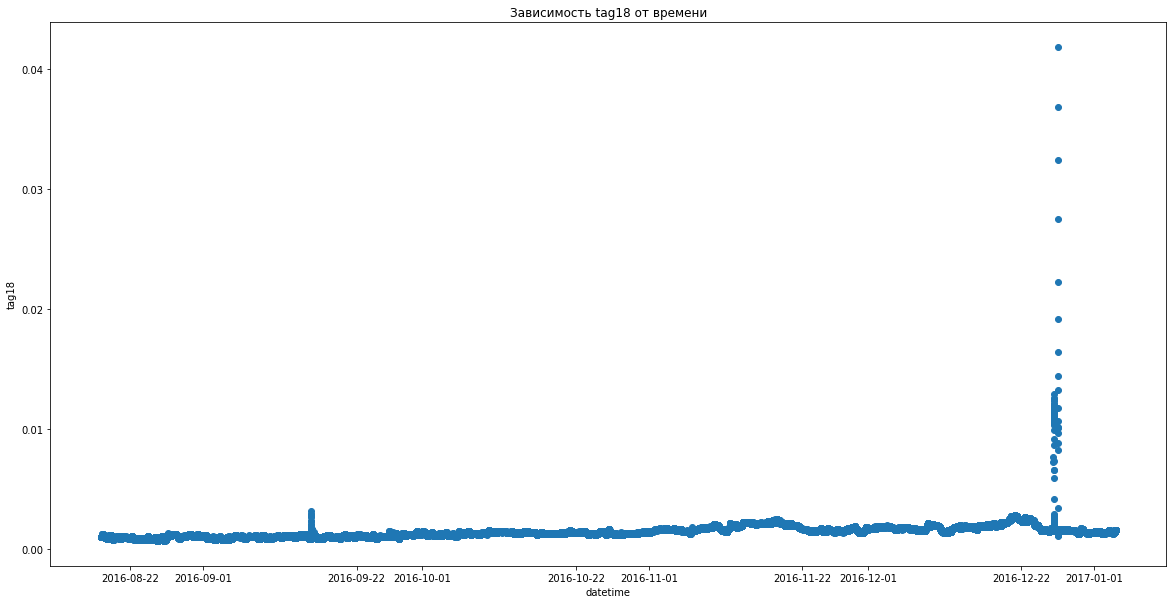

In [50]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', y = 'tag18', data = train_df)
plt.title('Зависимость tag18 от времени')
plt.xlabel('datetime')
plt.ylabel('tag18')
plt.show()

In [51]:
train_df.datetime[train_df.tag18 > 0.01]

187762   2016-12-26 09:22:00
187763   2016-12-26 09:23:00
187764   2016-12-26 09:24:00
187765   2016-12-26 09:25:00
187766   2016-12-26 09:26:00
                 ...        
188658   2016-12-27 00:18:00
188659   2016-12-27 00:19:00
188660   2016-12-27 00:20:00
188661   2016-12-27 00:21:00
188662   2016-12-27 00:22:00
Name: datetime, Length: 88, dtype: datetime64[ns]

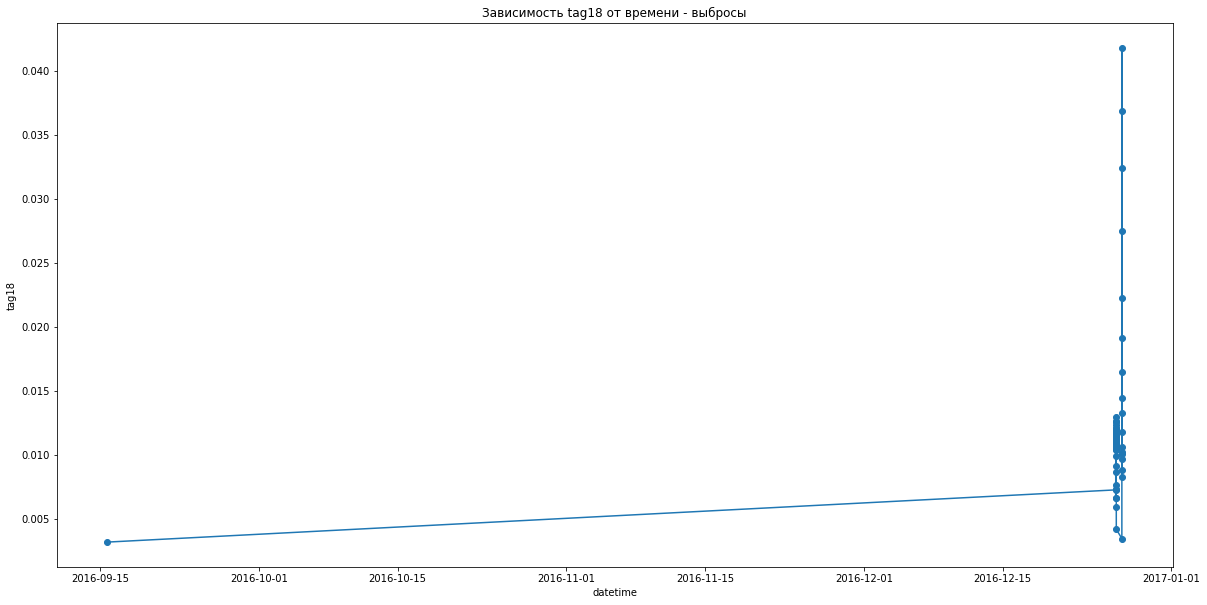

In [52]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag18', 
              data = train_df[train_df.tag18 > 0.003],
              ls = '-')
plt.title('Зависимость tag18 от времени - выбросы')
plt.xlabel('datetime')
plt.ylabel('tag18')
plt.show()

Я всё же удалю эти выбросы, они находятся в разных областях и не похоже, что обладают ценностью

In [53]:
train_df.tag18[train_df.tag18 > 0.003] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


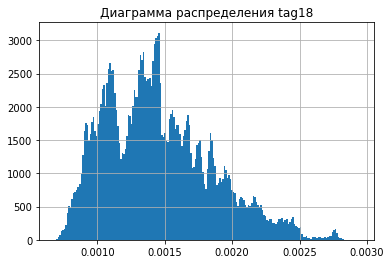

In [54]:
train_df.tag18.hist(bins=200)
plt.title('Диаграмма распределения tag18')
plt.show()

Посмотрим на этот столбец в тестовом датасете

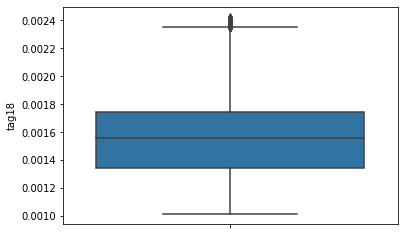

In [117]:
sns.boxplot(y = test_df.tag18)
plt.show()

Похоже, что он уже очищен, здесь таких выбросов нет

Теперь посмотрим на **tag44**

####tag44

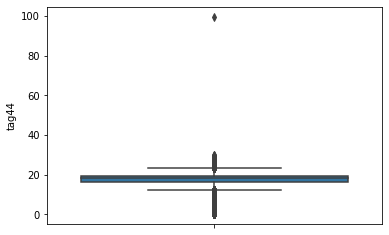

In [55]:
sns.boxplot(y = train_df.tag44)
plt.show()

Явный выброс у значения 100

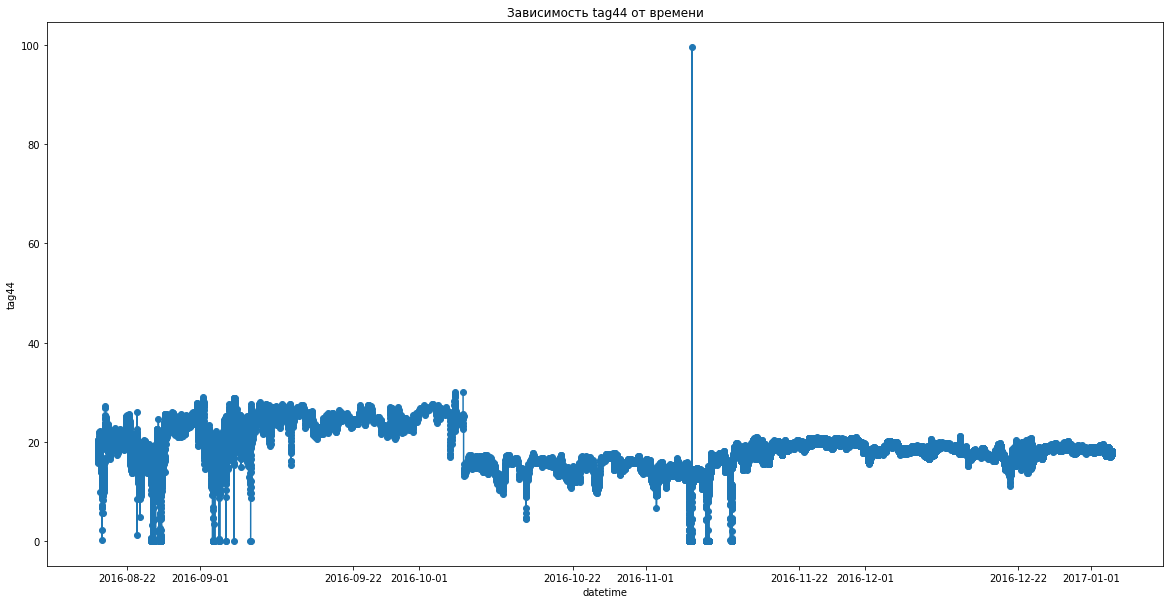

In [56]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', y = 'tag44', data = train_df, ls = '-')
plt.title('Зависимость tag44 от времени')
plt.xlabel('datetime')
plt.ylabel('tag44')
plt.show()

In [57]:
train_df.tag44[train_df.tag44 > 50] = np.nan
train_df.tag44[train_df.tag44 < 8] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


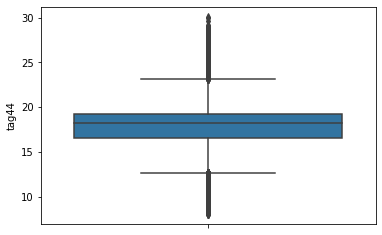

In [58]:
sns.boxplot(y = train_df.tag44)
plt.show()

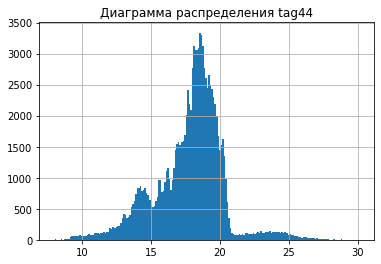

In [59]:
train_df.tag44.hist(bins = 200)
plt.title('Диаграмма распределения tag44')
plt.show()

Удаление выбросов дало значительно более наглядную гистограмму. При нормализации этого столбца это также сильно повлияет на результат.


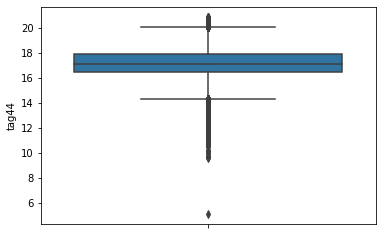

In [118]:
sns.boxplot(y = test_df.tag44)
plt.show()

В тестовом датасете этот столбец имеет аномальные значения в нижней части столбца. От 12 и ниже можно убирать
Далее разберемся с **tag45**

####tag45

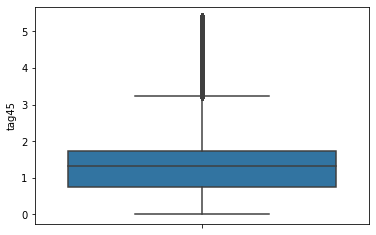

In [60]:
sns.boxplot(y = train_df.tag45)
plt.show()

In [61]:
train_df.tag45[train_df.tag45 > 3.5]

857       3.510618
861       3.510618
862       3.731849
871       3.767752
872       3.705824
            ...   
149308    3.587402
149309    3.585632
149310    3.564688
149311    3.581640
149312    3.615421
Name: tag45, Length: 3851, dtype: float64

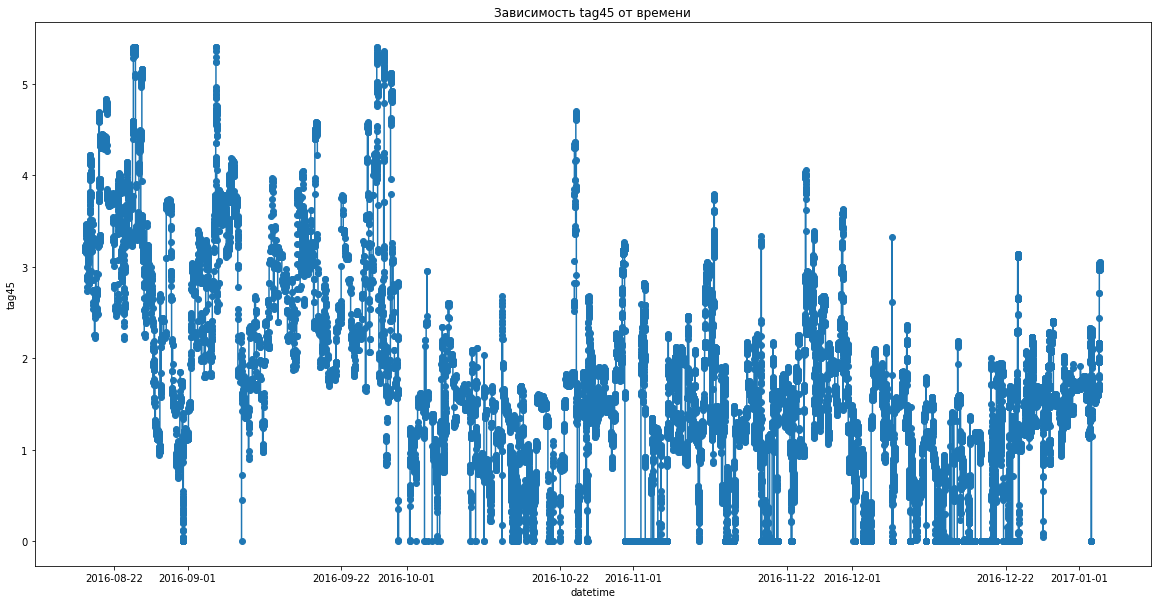

In [62]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', y = 'tag45', data = train_df, ls = '-')
plt.title('Зависимость tag45 от времени')
plt.xlabel('datetime')
plt.ylabel('tag45')
plt.show()

Не стану удалять, так как не вижу явных уникальных отклонений.

Теперь **tag58**

####tag58

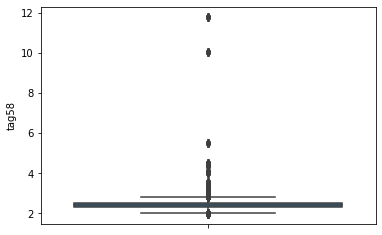

In [63]:
sns.boxplot(y = train_df.tag58)
plt.show()

Видны сильные выбросы у значений 10 и 12

In [64]:
train_df.tag58[train_df.tag58 > 4]

118523     4.085657
118524     4.083936
118525     4.087818
118526     4.088624
118527     4.085412
            ...    
134403    11.791630
134404    11.792540
134405    11.793280
134406    11.791320
134407    11.791210
Name: tag58, Length: 105, dtype: float64

Хмм, кажется, они также расположены в одном временном интервале.

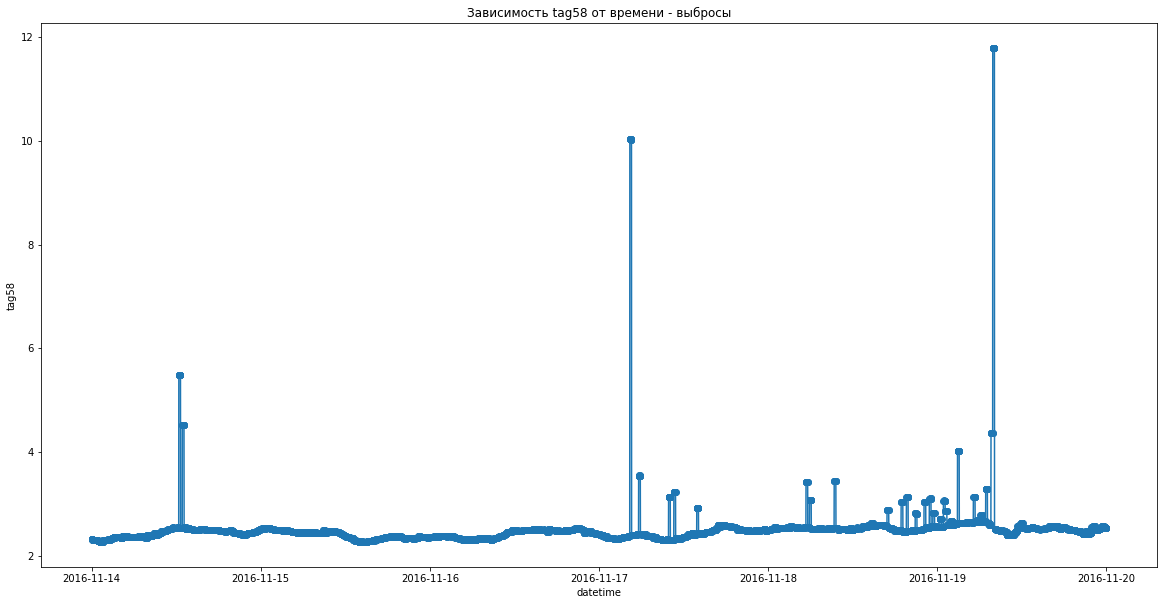

In [65]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag58', 
              data = train_df[((train_df.datetime > datetime.datetime(2016,11,14)) & (train_df.datetime < datetime.datetime(2016,11,20)))], 
              ls = '-')
plt.title('Зависимость tag58 от времени - выбросы')
plt.xlabel('datetime')
plt.ylabel('tag58')
plt.show()

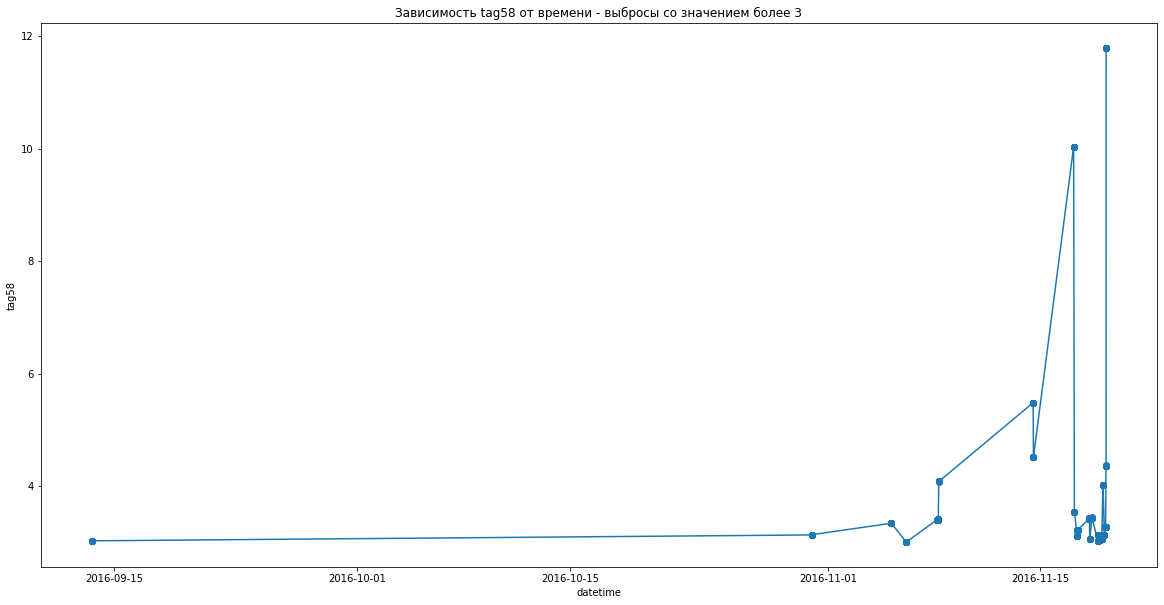

In [66]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag58', 
              data = train_df[train_df.tag58 > 3], 
              ls = '-')
plt.title('Зависимость tag58 от времени - выбросы со значением более 3')
plt.xlabel('datetime')
plt.ylabel('tag58')
plt.show()

Очевидно, это какие-то сгруппированные события. Не стану их оставлять, так как они могут сильно повлиять на весь столбец


In [67]:
train_df.tag58[train_df.tag58 > 3] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


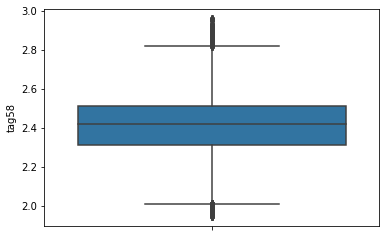

In [68]:
sns.boxplot(y = train_df.tag58)
plt.show()

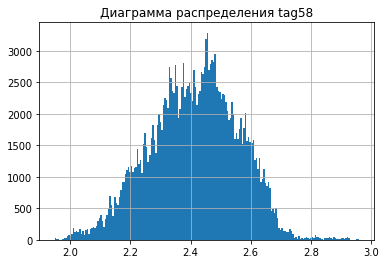

In [69]:
train_df.tag58.hist(bins = 200)
plt.title('Диаграмма распределения tag58')
plt.show()

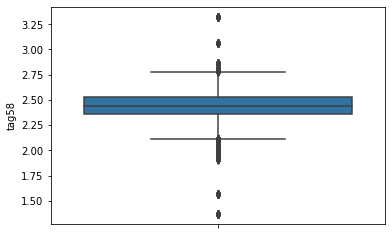

In [122]:
sns.boxplot(y = test_df.tag58)
plt.show()

В тестовой части необходимо избавиться от значений больше 3 и меньше 1.75


Следующий на очереди **tag60**

####tag60

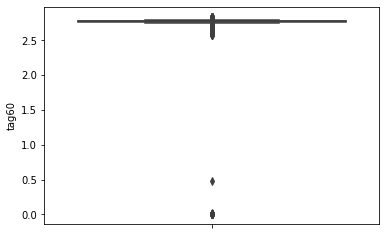

In [70]:
sns.boxplot(y = train_df.tag60)
plt.show()

In [71]:
train_df.tag60[train_df.tag60 < 1]

140232    0.000623
140233    0.000784
140234    0.000758
140235    0.000729
140236    0.027324
140237    0.007213
140238    0.000171
140239    0.000317
140240    0.000259
140241    0.002472
140242    0.000407
140243    0.012220
140244    0.002964
140245    0.000468
140246    0.000279
140247    0.000337
140248    0.000381
140249    0.000289
140250    0.000285
140251    0.000284
140252    0.000511
140253    0.000373
140254    0.000614
140255    0.000653
140256    0.000338
140257    0.000330
140258    0.000439
140259    0.000097
140260    0.000292
140261    0.000385
140262    0.000406
140263    0.481294
Name: tag60, dtype: float64

По индексам видно, что эти значения также сгруппированы в одной части датасета

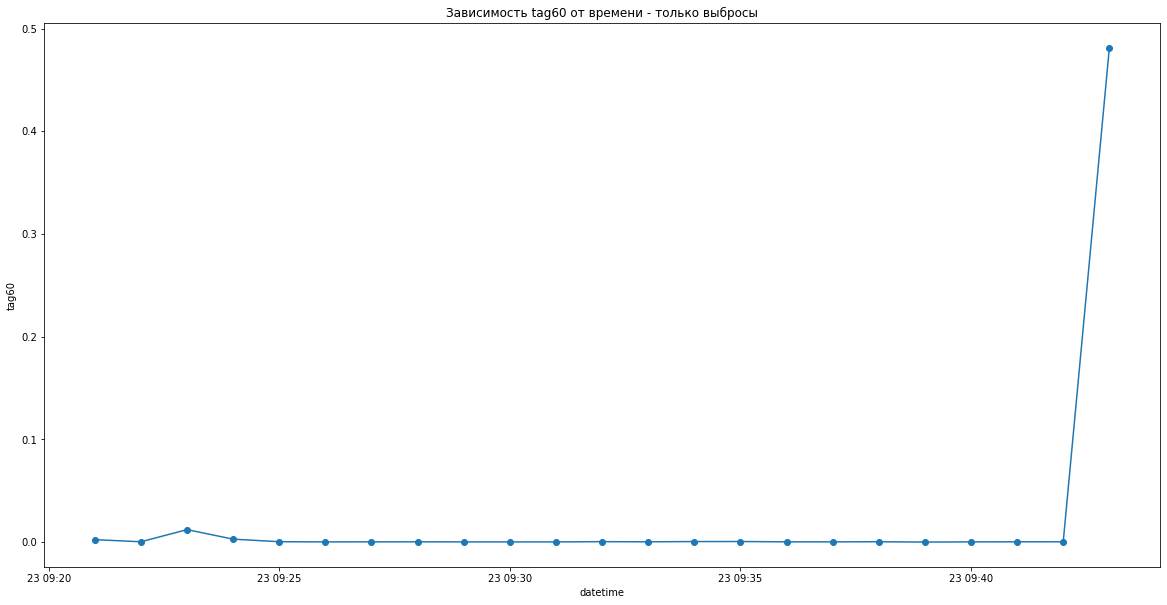

In [72]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag60', 
              data = train_df.iloc[140232:140255], 
              ls = '-')
plt.title('Зависимость tag60 от времени - только выбросы')
plt.xlabel('datetime')
plt.ylabel('tag60')
plt.show()

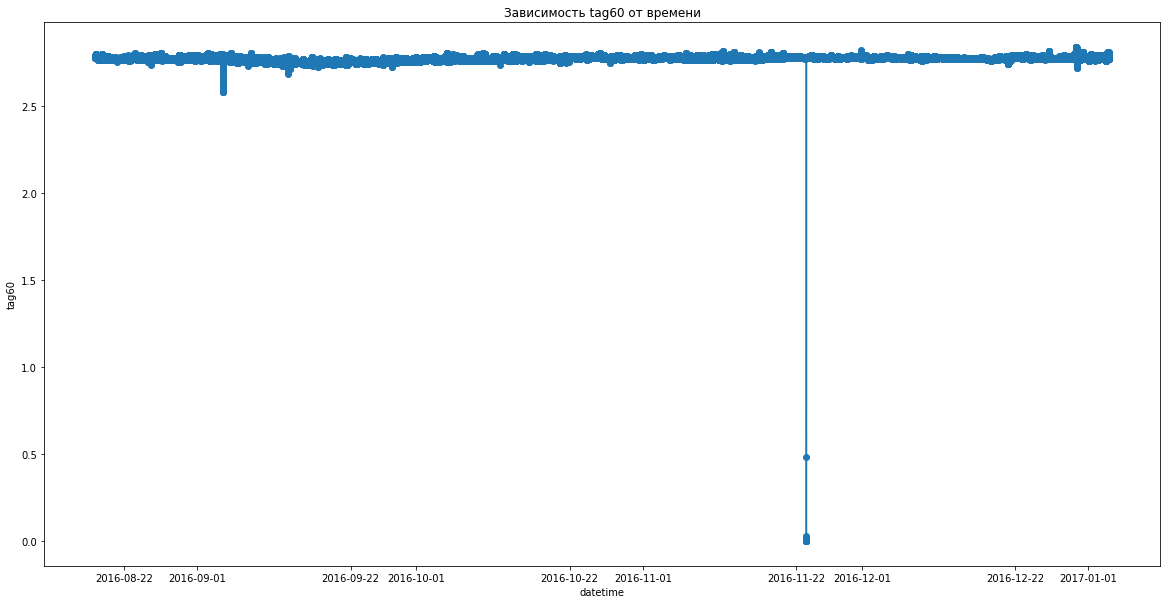

In [73]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag60', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag60 от времени')
plt.xlabel('datetime')
plt.ylabel('tag60')
plt.show()

Несмотря на то, что выбросы не кажутся случайными, я решил от них избавиться, чтобы модель была точнее на всех других данных.

In [74]:
train_df.tag60[train_df.tag60 < 1] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


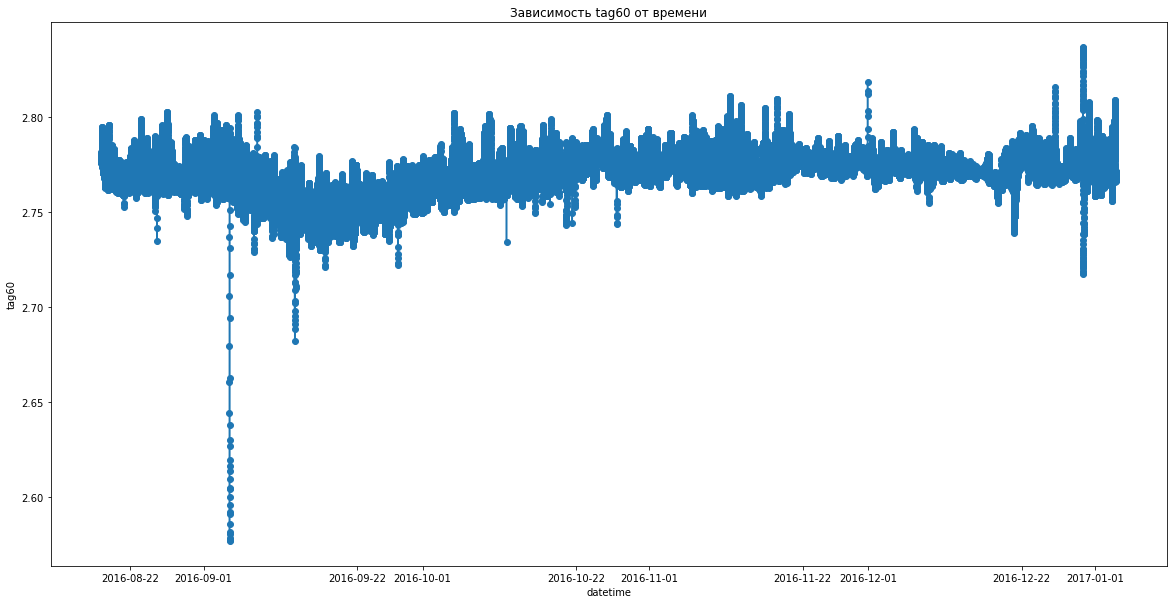

In [75]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag60', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag60 от времени')
plt.xlabel('datetime')
plt.ylabel('tag60')
plt.show()

Похоже, есть ещё одна область с выбросами, менее очевидными.

In [76]:
train_df.tag60[train_df.tag60 < 2.68]

25277    2.679618
25278    2.660623
25279    2.644403
25280    2.629950
25281    2.616379
25282    2.604224
25283    2.592316
25284    2.581945
25285    2.577537
25286    2.577003
25287    2.578453
25288    2.580963
25289    2.586220
25290    2.591484
25291    2.595942
25292    2.599927
25293    2.604751
25294    2.609707
25295    2.613703
25296    2.619608
25297    2.626777
25298    2.637836
25299    2.662950
Name: tag60, dtype: float64

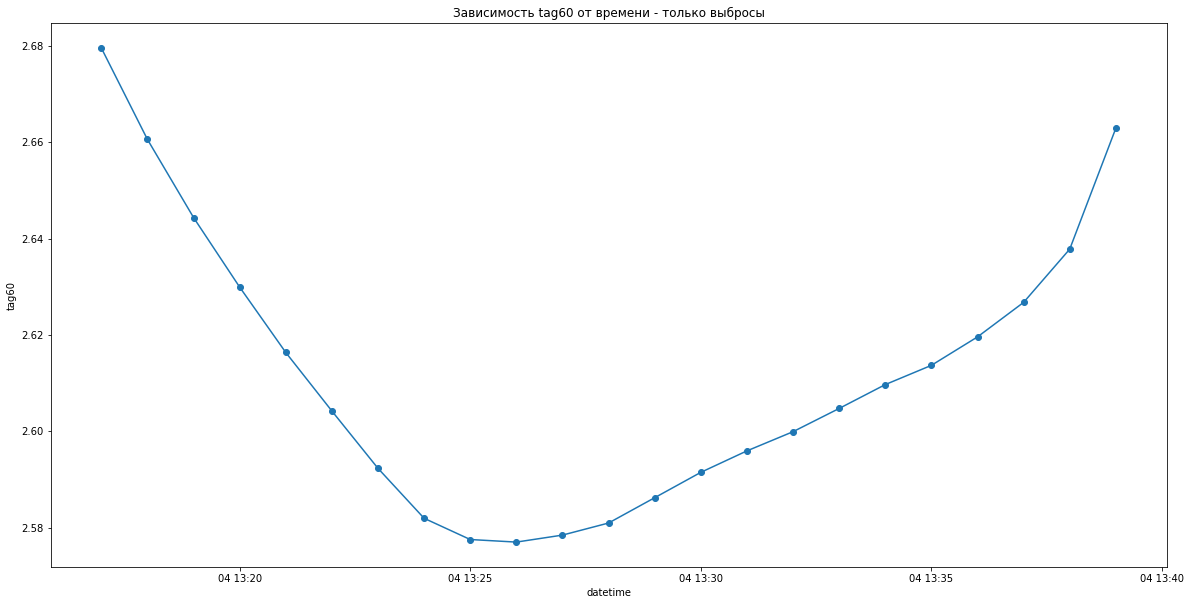

In [77]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag60', 
              data = train_df[train_df.tag60 < 2.68], 
              ls = '-')
plt.title('Зависимость tag60 от времени - только выбросы')
plt.xlabel('datetime')
plt.ylabel('tag60')
plt.show()

In [78]:
train_df.tag60[train_df.tag60 < 2.68] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


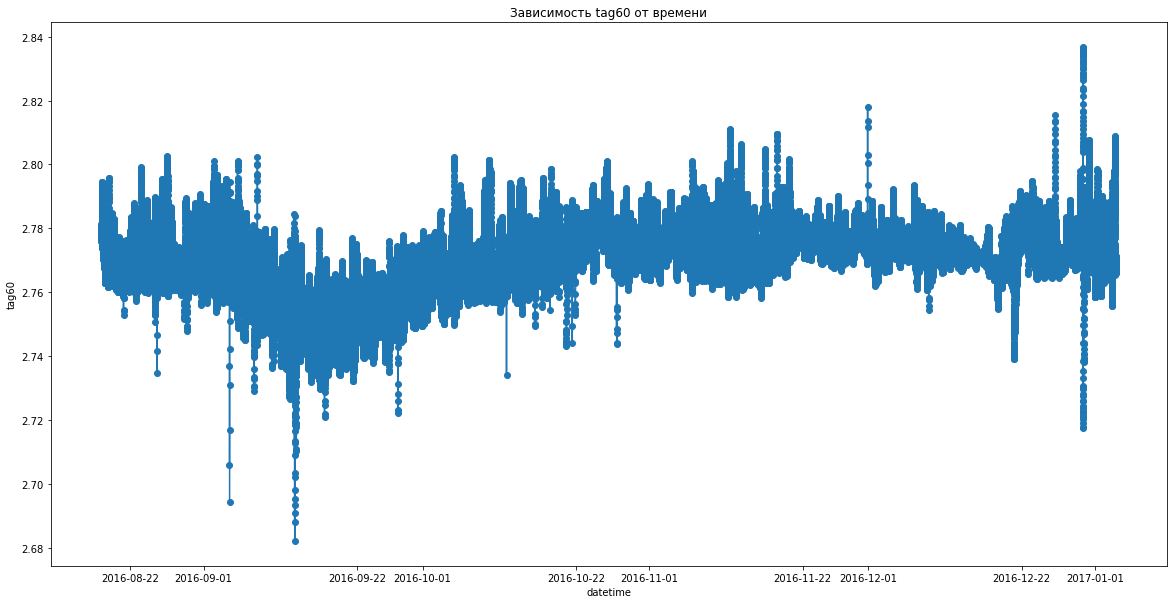

In [79]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag60', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag60 от времени')
plt.xlabel('datetime')
plt.ylabel('tag60')
plt.show()

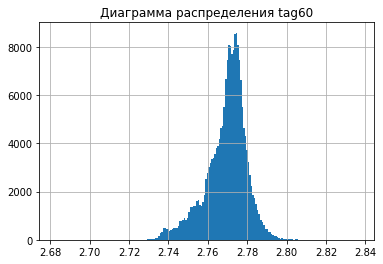

In [80]:
train_df.tag60.hist(bins = 200)
plt.title('Диаграмма распределения tag60')
plt.show()

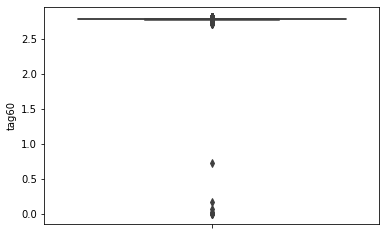

In [123]:
sns.boxplot(y = test_df.tag60)
plt.show()

В тестовом датасете та же проблема.

C **tag60** закончили, приступим к **tag64**

####tag64

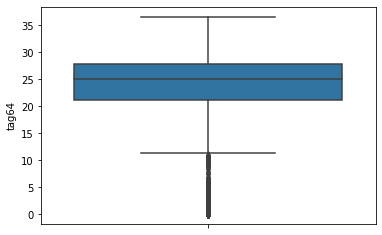

In [81]:
sns.boxplot(y = train_df.tag64)
plt.show()

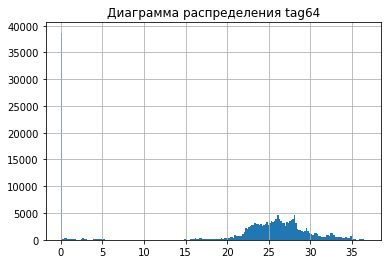

In [82]:
train_df.tag64.hist(bins = 200)
plt.title('Диаграмма распределения tag64')
plt.show()

In [83]:
train_df.tag64[train_df.tag64 < 16]

116891    15.95623
116892    15.80219
116893    15.66215
116894    15.52201
116895    15.37924
            ...   
163372    15.95933
163373    15.95380
163374    15.95070
163375    15.93819
163376    15.95432
Name: tag64, Length: 42917, dtype: float64

Хмм, хотя значения ниже 16 кажутся выбросами, их в датасете слишком много - более 42 тысяч экземпляров. Можно ли их считать выбросами или это особенность данных в этом столбце? Я склоняюсь ко второму. Посмотрю на график по времени.

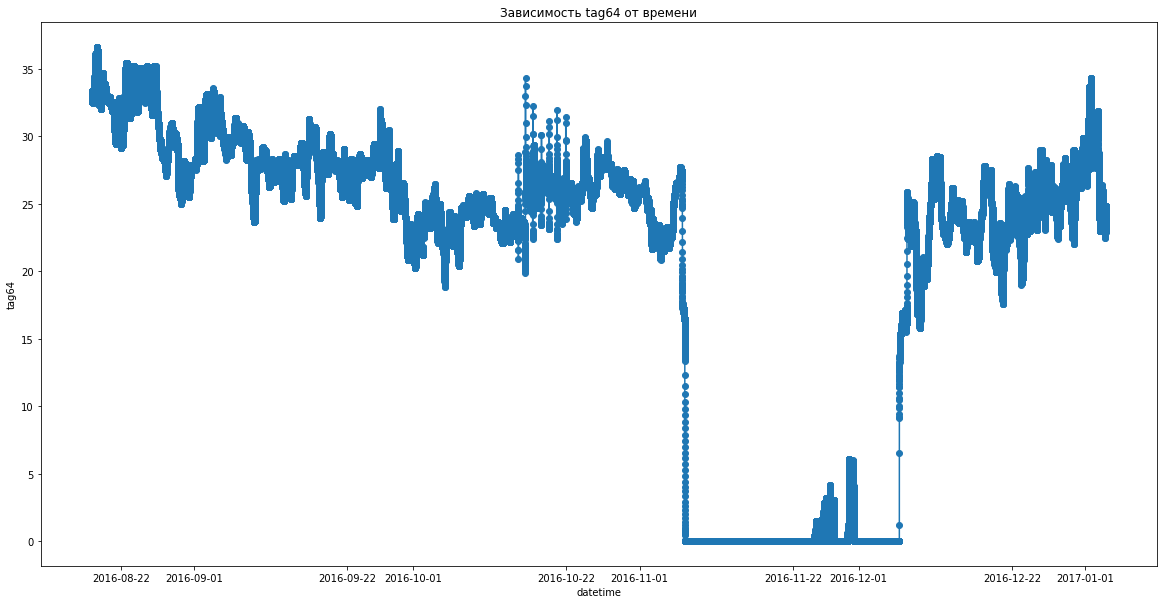

In [84]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag64', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag64 от времени')
plt.xlabel('datetime')
plt.ylabel('tag64')
plt.show()

Хмм, выглядит конечно очень странно. Для принятия решения посмотрю, как выглядит аналогичный столбец в тестовой выборке.

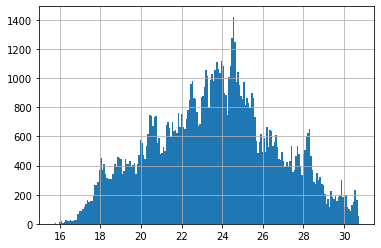

In [85]:
test_df.tag64.hist(bins = 200)
plt.show()

Мы видим, что в другой выборке таких значений в этом столбце нет, поэтому будем считать их выбросами и заменим впоследствии.

In [86]:
train_df.tag64[train_df.tag64 < 16] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


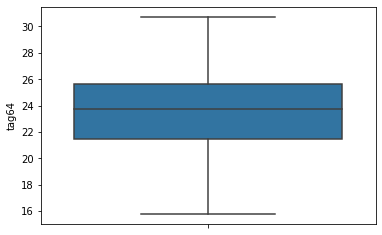

In [125]:
sns.boxplot(y = test_df.tag64)
plt.show()

В тестовом датасете этот столбец таких выбросов не содержит

Ну и наконец, **tag78**

####tag78

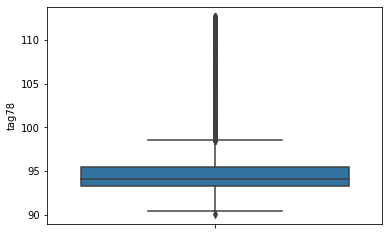

In [87]:
sns.boxplot(y = train_df.tag78)
plt.show()

In [88]:
train_df.tag78[train_df.tag78 > 100]

130400    100.1617
130405    100.1591
130409    100.2915
130413    100.1605
130417    100.0757
            ...   
184045    101.2621
184049    100.9825
184053    100.7947
184057    100.5431
184062    100.2970
Name: tag78, Length: 1429, dtype: float64

1400 экземпляров - немало. Проверим, как они расположены на графике по времени.

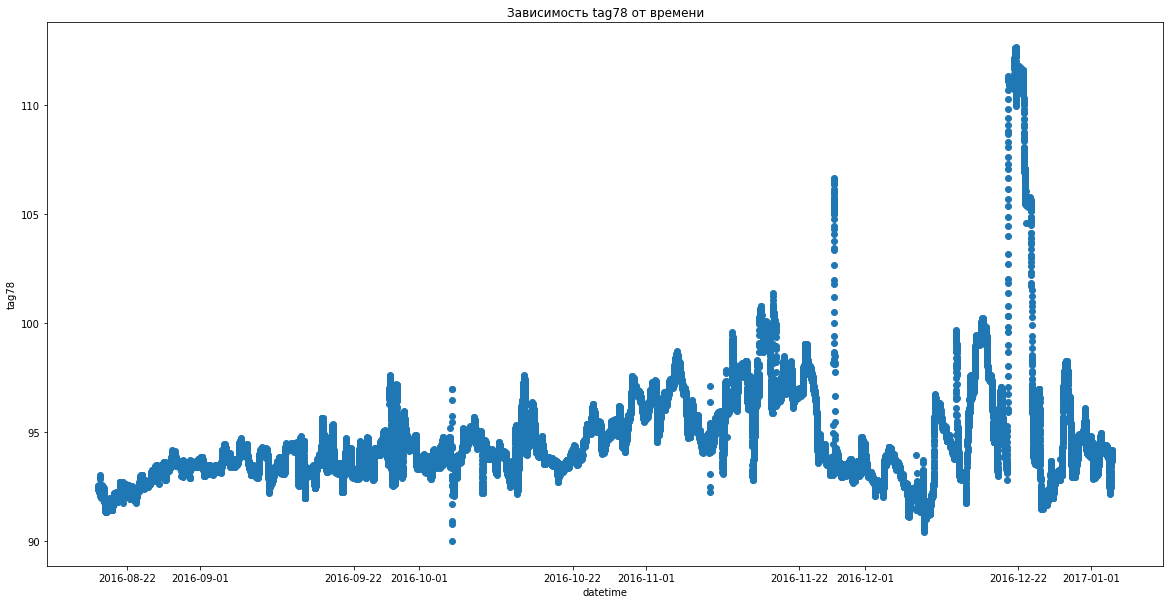

In [89]:
plt.figure(figsize = (20,10))
plt.plot_date(x = 'datetime', 
              y = 'tag78', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag78 от времени')
plt.xlabel('datetime')
plt.ylabel('tag78')
plt.show()

Похоже на выбросы, они явно выбиваются из графика. Соответственно, я их удалю

In [90]:
train_df.tag78[train_df.tag78 > 100] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


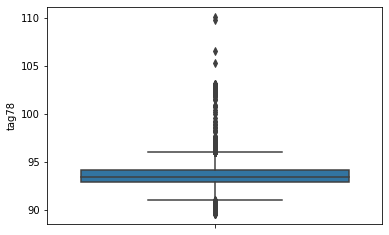

In [126]:
sns.boxplot(y = test_df.tag78)
plt.show()

В тестовой выборке необходимо будет удалить значения более 97

На этом мы закончили работу с выбросами. Я снова взгляну на диаграммы распределений тренировочного датасета, для проверки.

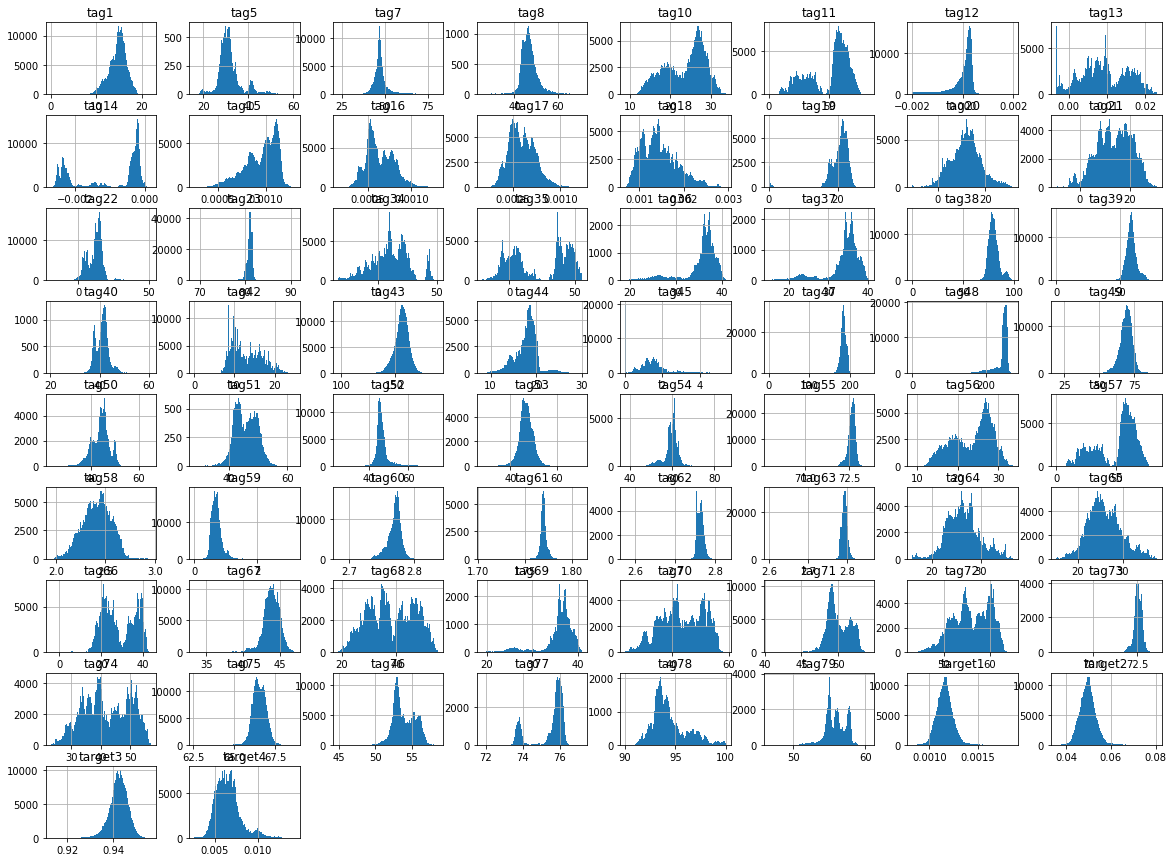

In [91]:
train_df.hist(bins = 100, figsize = (20,15))
plt.show()

### Нормализация

В этом разделе я приведу данные к единому масштабу. Значения каждого столбца будут в промежутке от 0 до 1, где 0 будет равно ранее минимальное значение, а 1 - максимальное. Реализую с помощью функции MinMaxScaler библиотеки sklearn.

In [92]:
for column in train_df.drop(target_columns + ['datetime'], axis = 1):
    train_df[column] = MinMaxScaler().fit_transform(np.array(train_df[column]).reshape(-1,1))

In [93]:
train_df.describe()

,tag1,tag5,tag7,tag8,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag42,tag43,tag44,tag45,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,199925.000000,9736.000000,88119.000000,16776.000000,199828.000000,199858.000000,175248.000000,199866.000000,199852.000000,199866.000000,199866.000000,199866.000000,199763.000000,100167.000000,199858.000000,199858.000000,199858.000000,199858.000000,199858.000000,199858.000000,39211.000000,38039.000000,158305.000000,152967.000000,15577.000000,199854.000000,199858.000000,110560.000000,113799.000000,199858.000000,132348.000000,199857.000000,78118.000000,14722.000000,101783.000000,84180.000000,59434.000000,199858.000000,199828.000000,199858.000000,199423.000000,199110.000000,199811.000000,35801.000000,36717.000000,199866.000000,156941.000000,199858.000000,199858.000000,199858.000000,199858.000000,37643.000000,199858.000000,199858.000000,199858.000000,35078.000000,199858.000000,199858.000000,199858.000000,48800.000000,47242.000000,48556.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,0.668491,0.352431,0.427333,0.472566,0.594585,0.602291,0.497832,0.474066,0.584117,0.664636,0.418327,0.400153,0.340660,0.695096,0.527528,0.581593,0.439657,0.552554,0.524192,0.580039,0.758273,0.754480,0.807089,0.752692,0.510903,0.518819,0.637828,0.442775,0.243851,0.745199,0.893512,0.701007,0.496566,0.513584,0.440591,0.441352,0.463391,0.827504,0.594585,0.602291,0.458585,0.225186,0.564814,0.615695,0.746787,0.754744,0.504441,0.486746,0.681196,0.766209,0.531450,0.766332,0.565649,0.695824,0.585966,0.819964,0.554753,0.647679,0.661536,0.679949,0.440406,0.664871,0.001156,0.049836,0.942428,0.006580
std,0.085096,0.112716,0.077188,0.085105,0.196817,0.203429,0.120792,0.242819,0.334602,0.158293,0.136011,0.130023,0.175757,0.137893,0.150558,0.173743,0.075972,0.025462,0.184715,0.281306,0.169779,0.167895,0.051709,0.048655,0.066129,0.147073,0.068693,0.113132,0.174362,0.027145,0.066968,0.062015,0.087375,0.108161,0.068097,0.069079,0.067794,0.037414,0.196817,0.203429,0.143989,0.056537,0.067149,0.034814,0.033570,0.029131,0.167781,0.168704,0.163840,0.081990,0.229270,0.160745,0.209852,0.112818,0.183687,0.041233,0.229109,0.064145,0.109880,0.161332,0.171003,0.103892,0.000085,0.003685,0.003936,0.001442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000826,0.035611,0.912861,0.002595
25%,0.617391,0.290467,0.392661,0.420980,0.428683,0.419761,0.476553,0.310155,0.159441,0.561013,0.318064,0.303175,0.197273,0.664008,0.430168,0.451453,0.384423,0.542960,0.408247,0.312998,0.743942,0.731161,0.772328,0.722410,0.461763,0.395578,0.599034,0.387551,0.136519,0.728812,0.893717,0.665599,0.440216,0.429821,0.406354,0.400549,0.439341,0.808294,0.428683,0.419761,0.360981,0.189508,0.530932,0.599012,0.722505,0.736366,0.388249,0.369991,0.538133,0.718179,0.340685,0.747009,0.403413,0.613085,0.445938,0.798640,0.371865,0.603048,0.579940,0.676827,0.327274,0.599100,0.001101,0.047461,0.940184,0.005565
50%,0.678626,0.335619,0.416176,0.463689,0.651192,0.681495,0.540118,0.462592,0.804853,0.703724,0.391007,0.385973,0.320154,0.725975,0.533000,0.590950,0.452618,0.556894,0.522523,0.726616,0.801313,0.793829,0.800518,0.750799,0.516849,0.482637,0.642329,0.460721,0.243471,0.744969,0.914219,0.705987,0.

Видно, что все столбцы приняли значения от 0 до 1.

###Заполнение пропущенных значений

В данном разделе я буду заполнять пропуски в столбцах. На мой взгляд, лучшим решением будет использовать не фиксированное значение (ноль, среднее, медиана и т.д.), а использовать интерполяцию для каждого столбца в зависимости от времени. Для данной задачи было бы хорошо использовать отдельную нейросеть или алгоритм SARIMA для работы с временными рядами, особенно учитывая хаотичность временных рядов в столбцах.

In [94]:
train_df.set_index('datetime', inplace = True)

Сейчас я попробую на примере одного столбца провести интерполяцию. Для этого мне необходимо разделить столбец на тренировочную и тестовую часть. Тестовой будет та часть, где содержатся пропуски - ведь наша задача состоит в том, чтобы предсказать значения на их месте и заполнить столбец этими значениями. Тренировочными будут все остальные данные.

In [95]:
tag64_test = train_df.tag64[train_df.tag64.isna()]
tag64_train = train_df.tag64.dropna()

Теперь инициализирую модель ARIMA для предсказания значений временного ряда.

In [96]:
arima = ARIMA(tag64_train, order=(5,1,0))
arima_fit = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [97]:
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.tag64   No. Observations:               156940
Model:                 ARIMA(5, 1, 0)   Log Likelihood              745661.905
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 31 Mar 2021   AIC                       -1491309.810
Time:                        13:53:44   BIC                       -1491240.065
Sample:                             1   HQIC                      -1491289.064
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.718e-06   8.73e-06     -0.311      0.756   -1.98e-05    1.44e-05
ar.L1.D.tag64     0.4754      0.003    188.336      0.000       0.470       0.480
ar.L2.D.tag64    -0.0121      0.003     

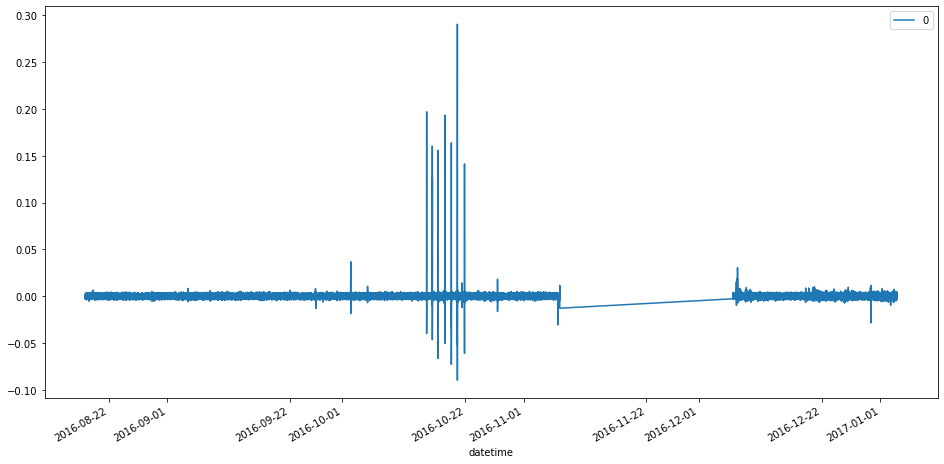

In [98]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot(figsize = (16,8))
plt.show()

На графике видно ошибки в предсказанных значениях. Большой разброс в середине графика связан с неочищенными выбросами в этой области. В остальном график сосредоточен близко у нулевого значения. Сейчас попробую предсказать пропущенные значения столбца.


In [99]:
'''
tag64_X = tag64_train.values
tag64_X_train, tag64_val = train_test_split(tag64_X)
history = [x for x in tag64_X_train]
predictions = list()
'''

'\ntag64_X = tag64_train.values\ntag64_X_train, tag64_val = train_test_split(tag64_X)\nhistory = [x for x in tag64_X_train]\npredictions = list()\n'

In [100]:
'''
for t in range(len(tag64_val)):
	arima_model = ARIMA(history, order=(5,1,0))
	arima_model_fit = arima_model.fit()
	output = arima_model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = tag64_val[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
'''

"\nfor t in range(len(tag64_val)):\n\tarima_model = ARIMA(history, order=(5,1,0))\n\tarima_model_fit = arima_model.fit()\n\toutput = arima_model_fit.forecast()\n\tyhat = output[0]\n\tpredictions.append(yhat)\n\tobs = tag64_val[t]\n\thistory.append(obs)\n\tprint('predicted=%f, expected=%f' % (yhat, obs))\n"

In [101]:
'''
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
'''

"\nrmse = sqrt(mean_squared_error(test, predictions))\nprint('Test RMSE: %.3f' % rmse)\n"

In [102]:
'''
plt.plot(tag64_val)
plt.plot(predictions, color='red')
plt.show()
'''

"\nplt.plot(tag64_val)\nplt.plot(predictions, color='red')\nplt.show()\n"

В предыдущих строках представлен алгоритм предсказания временного ряда с последующей валидацией и отрисовкой графика (но только по одному столбцу). Проблема в том, что это занимает много времени. Поэтому сейчас я воспользуюсь методом interpolate библиотеки pandas.

In [103]:
train_df.tag64.interpolate(method = 'linear', inplace = True)

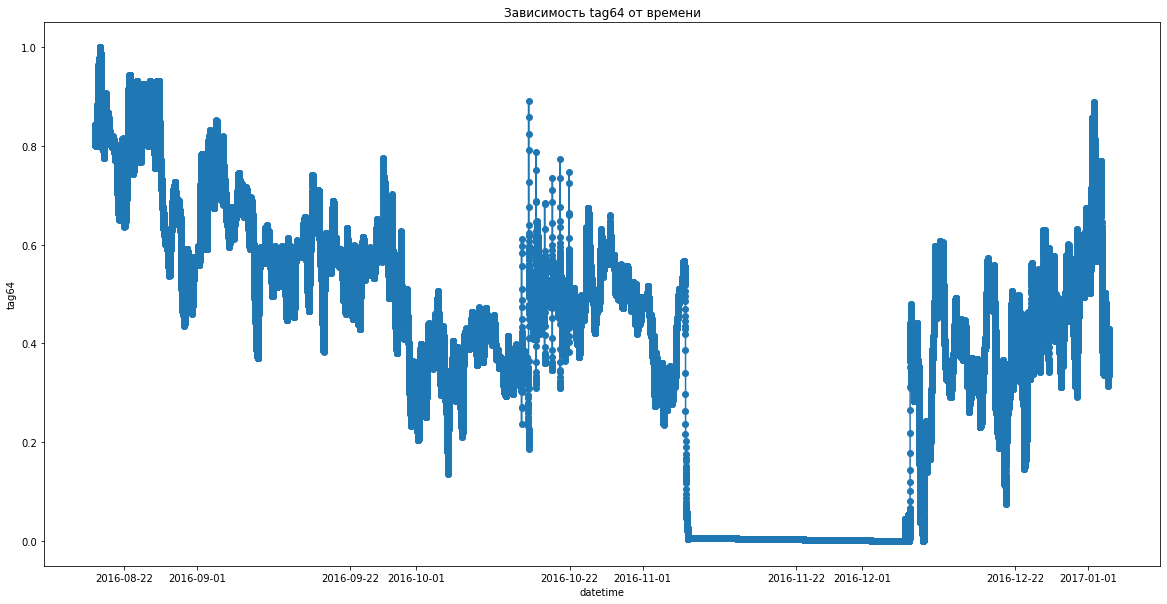

In [104]:
plt.figure(figsize = (20,10))
plt.plot_date(x = train_df.index, 
              y = 'tag64', 
              data = train_df, 
              ls = '-')
plt.title('Зависимость tag64 от времени')
plt.xlabel('datetime')
plt.ylabel('tag64')
plt.show()

Качество такого заполнения значительно хуже, но к сожалению сроки не позволяют сделать другую модель. Далее я пройдусь по каждому столбцу для заполнения подобным способом пустых значений.

In [105]:
for column in train_df:
    train_df[column].interpolate(method = 'linear', inplace = True)

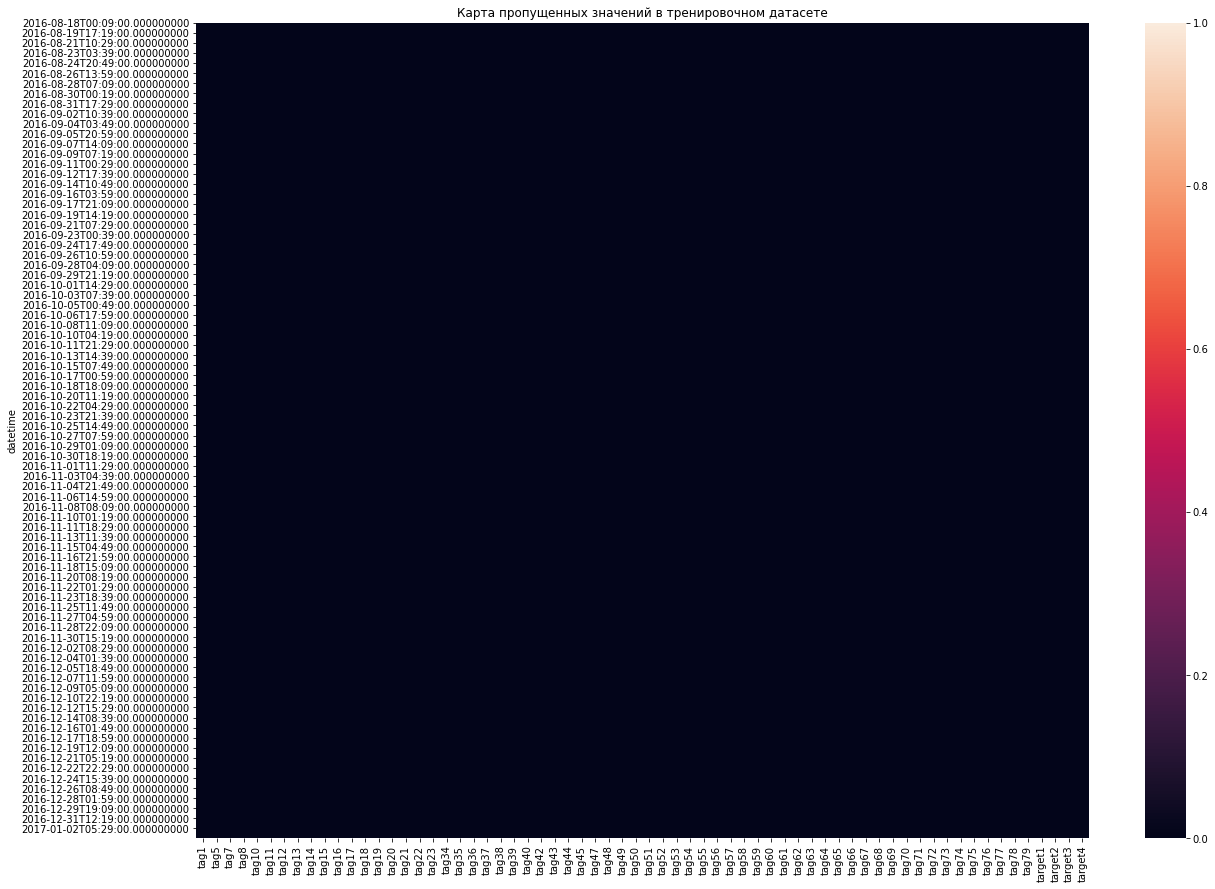

In [106]:
plt.figure(figsize = (20,15))
plt.title('Карта пропущенных значений в тренировочном датасете')
sns.heatmap(train_df.isna())
plt.show()

Видно, что пустых значений не осталось

##Обучение модели

Теперь, когда данные обработаны, можем построить уже более эффективную модель. Разделим датасет train_df на целевые переменные "y" и массив признаков "X".

In [107]:
X = train_df.drop(columns = target_columns)
y = train_df[target_columns]

Дальше разделим их на выборки для обучения и валидации модели.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [112]:
model = catboost.CatBoostRegressor(objective = 'MultiRMSE', random_state = 10)
model.fit(X_train, y_train)

0:	learn: 0.0055036	total: 224ms	remaining: 3m 43s
1:	learn: 0.0054236	total: 442ms	remaining: 3m 40s
2:	learn: 0.0053469	total: 671ms	remaining: 3m 42s
3:	learn: 0.0052728	total: 908ms	remaining: 3m 46s
4:	learn: 0.0052016	total: 1.15s	remaining: 3m 49s
5:	learn: 0.0051341	total: 1.36s	remaining: 3m 45s
6:	learn: 0.0050646	total: 1.63s	remaining: 3m 50s
7:	learn: 0.0049984	total: 1.86s	remaining: 3m 50s
8:	learn: 0.0049339	total: 2.07s	remaining: 3m 48s
9:	learn: 0.0048726	total: 2.29s	remaining: 3m 46s
10:	learn: 0.0048134	total: 2.51s	remaining: 3m 45s
11:	learn: 0.0047566	total: 2.75s	remaining: 3m 46s
12:	learn: 0.0047019	total: 2.99s	remaining: 3m 47s
13:	learn: 0.0046461	total: 3.2s	remaining: 3m 45s
14:	learn: 0.0045935	total: 3.4s	remaining: 3m 43s
15:	learn: 0.0045424	total: 3.63s	remaining: 3m 43s
16:	learn: 0.0044894	total: 3.84s	remaining: 3m 42s
17:	learn: 0.0044412	total: 4.09s	remaining: 3m 43s
18:	learn: 0.0043929	total: 4.29s	remaining: 3m 41s
19:	learn: 0.0043490	tot

In [113]:
predictions = model.predict(X_test)
print('Метрика R^2 показала результат ' + str(r2_score(y_test, predictions)))
print('Метрика RMSE показала результат ' + str(mean_squared_error(y_test, predictions, squared = False)))

Метрика R^2 показала результат 0.9748201748488047
Метрика RMSE показала результат 0.00046937279674285666


##Получение результатов

Теперь, когда мы обучили и протестировали нашу модель, пора её применить на тестовых данных. Для начала приведем эти данные к виду, понятной для нашей модели - то есть проведём с ними те же операции.

In [129]:
# Сделать индекс из столбца с датой и временем
test_df['Unnamed: 0'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df.rename({'Unnamed: 0': 'datetime'}, axis = 1, inplace = True)
test_df.set_index('datetime')
# Удаление ненужных столбцов
global columns_to_drop
test_df.drop(columns = columns_to_drop, inplace = True)
# Удаление выбросов
test_df.tag12[test_df.tag12 > 0.002] = np.nan
test_df.tag12[test_df.tag12 < -0.002] = np.nan
test_df.tag44[test_df.tag44 < 12] = np.nan
test_df.tag58[test_df.tag58 > 3] = np.nan
test_df.tag58[test_df.tag58 < 1.75] = np.nan
test_df.tag60[test_df.tag60 < 1] = np.nan
test_df.tag78[test_df.tag78 > 97] = np.nan
# Нормализация и интерполяция
for column in test_df:
    test_df[column] = MinMaxScaler().fit_transform(np.array(test_df[column]).reshape(-1,1))
    test_df[column].interpolate(method = 'linear', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by Inte

В качестве одного из заданий необходимо было получить десять наиболее важных признаков для обучения. Сделаю это с помощью встроенного метода библиотеки catboost get_feature_importance

In [131]:
model.get_feature_importance(prettified = True)[0:10]

,Feature Id,Importances
0,tag49,23.107192
1,tag59,13.379277
2,tag75,11.804454
3,tag42,11.589742
4,tag58,8.012754
5,tag43,7.438938
6,tag67,6.780375
7,tag71,3.562788
8,tag63,2.527221
9,tag66,1.925243


Теперь сравню их с первоначальной моделью

In [132]:
raw_model.get_feature_importance(prettified = True)[0:10]

,Feature Id,Importances
0,tag49,23.210903
1,tag59,16.047492
2,tag42,12.536421
3,tag58,9.255271
4,tag75,9.004069
5,tag43,7.134551
6,tag67,5.519014
7,tag63,3.531569
8,tag2,2.202232
9,tag1,2.116541


Интересно, они во многом совпадают, не считая последних двух столбцов.

Теперь получу предсказания для тестовой части.

In [133]:
test_predictions = model.predict(test_df)

In [134]:
test_predictions

array([[0.00155562, 0.06706186, 0.92688267, 0.00449985],
       [0.00154395, 0.06655868, 0.92739504, 0.00450233],
       [0.00152803, 0.06587457, 0.92808133, 0.00451607],
       ...,
       [0.00123198, 0.05310459, 0.94103245, 0.00463098],
       [0.00121336, 0.0523023 , 0.94184076, 0.00464357],
       [0.00121449, 0.05235133, 0.94176607, 0.0046681 ]])

In [138]:
Answer = pd.DataFrame(test_predictions, columns = ['target1','target2', 'target3', 'target4'])

In [140]:
Answer.to_csv('/content/drive/MyDrive/my_databases/test_predictions.csv')